In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import gym
import random
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v1')
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n

EPISODES = 500
EPISODES_TEST = int(EPISODES/2)
LEARNING_RATE = 0.0001
MEM_SIZE = 10000
BATCH_SIZE = 32
GAMMA = 0.95
EXPLORATION_MAX = 1.0
EXPLORATION_DECAY = 0.999
EXPLORATION_MIN = 0.001


FC1_DIMS = 1024
FC2_DIMS = 512
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
class Network(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.input_shape = env.observation_space.shape
        self.action_space = action_space

        self.fc1 = nn.Linear(*self.input_shape, FC1_DIMS)
        self.fc2 = nn.Linear(FC1_DIMS, FC2_DIMS)
        self.fc3 = nn.Linear(FC2_DIMS, self.action_space)

        self.optimizer = optim.Adam(self.parameters(), lr=LEARNING_RATE)
        self.loss = nn.MSELoss()
        self.to(DEVICE)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ReplayBuffer:
    def __init__(self):
        self.mem_count = 0

        self.states = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.actions = np.zeros(MEM_SIZE, dtype=np.int64)
        self.rewards = np.zeros(MEM_SIZE, dtype=np.float32)
        self.states_ = np.zeros((MEM_SIZE, *env.observation_space.shape),dtype=np.float32)
        self.dones = np.zeros(MEM_SIZE, dtype=np.bool)

    def add(self, state, action, reward, state_, done):
        mem_index = self.mem_count % MEM_SIZE

        self.states[mem_index]  = state.clone().detach().numpy()
        self.actions[mem_index] = action
        self.rewards[mem_index] = reward
        self.states_[mem_index] = state_.clone().detach().numpy()
        self.dones[mem_index] =  1 - done

        self.mem_count += 1

    def sample(self):
        MEM_MAX = min(self.mem_count, MEM_SIZE)
        batch_indices = np.random.choice(MEM_MAX, BATCH_SIZE, replace=True)

        states  = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        dones   = self.dones[batch_indices]

        return states, actions, rewards, states_, dones

class DQN_Solver:
    def __init__(self):
        self.memory = ReplayBuffer()
        self.exploration_rate = EXPLORATION_MAX
        self.network = Network()

    def choose_action(self, observation, eps_greedy=True):
        if eps_greedy and random.random() < self.exploration_rate:
            return env.action_space.sample(), 0.0

        state = observation
        state = state.to(DEVICE)
        state = state.unsqueeze(0)

        q_values = self.network(state)
        return torch.argmax(q_values).item(), q_values

    def learn(self):
        if self.memory.mem_count < BATCH_SIZE:
            return

        states, actions, rewards, states_, dones = self.memory.sample()
        states = torch.tensor(states , dtype=torch.float32).to(DEVICE)
        actions = torch.tensor(actions, dtype=torch.long).to(DEVICE)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(DEVICE)
        states_ = torch.tensor(states_, dtype=torch.float32).to(DEVICE)
        dones = torch.tensor(dones, dtype=torch.bool).to(DEVICE)

        batch_indices = np.arange(BATCH_SIZE, dtype=np.int64)
        states.requires_grad = True
        
        q_values = self.network(states)
        next_q_values = self.network(states_)

        predicted_value_of_now = q_values[batch_indices, actions]
        predicted_value_of_future = torch.max(next_q_values, dim=1)[0].detach()
        
        q_target = rewards + GAMMA * predicted_value_of_future * dones

        loss = self.network.loss(q_target, predicted_value_of_now)        
        self.network.optimizer.zero_grad()
        loss.backward()
        self.network.optimizer.step()

        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)

    def returning_epsilon(self):
        return self.exploration_rate

## Training the network (only run if wanting to train again)

In [3]:
agent_clean = DQN_Solver()
agent_clean.network.train()

best_reward = 0
average_reward = 0
episode_number = []
average_reward_number = []

for i in range(1, EPISODES):
    state = env.reset()
    score = 0

    while True:
        action, q_values = agent_clean.choose_action(state)
        
        state_, reward, done, info = env.step(action)
        agent_clean.memory.add(state, action, reward, state_, done)
        agent_clean.learn()
        state = state_
        score += reward

        if done:
            if score > best_reward:
                best_reward = score
            average_reward += score
            print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
            break

        episode_number.append(i)
        average_reward_number.append(average_reward/i)


/tmp/ipykernel_137/1353702249.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


Episode 1 Average Reward 14.0 Best Reward 14.0 Last Reward 14.0 Epsilon 1.0
Episode 2 Average Reward 17.5 Best Reward 21.0 Last Reward 21.0 Epsilon 0.996005996001
Episode 3 Average Reward 19.0 Best Reward 22.0 Last Reward 22.0 Epsilon 0.9743224148844496
Episode 4 Average Reward 17.75 Best Reward 22.0 Last Reward 14.0 Epsilon 0.9607702107358118
Episode 5 Average Reward 17.8 Best Reward 22.0 Last Reward 18.0 Epsilon 0.9436225637280606
Episode 6 Average Reward 17.0 Best Reward 22.0 Last Reward 13.0 Epsilon 0.9314288037569908
Episode 7 Average Reward 17.142857142857142 Best Reward 22.0 Last Reward 18.0 Epsilon 0.914804836692645
Episode 8 Average Reward 19.625 Best Reward 37.0 Last Reward 37.0 Epsilon 0.8815592697443159
Episode 9 Average Reward 19.555555555555557 Best Reward 37.0 Last Reward 19.0 Epsilon 0.8649595394300645
Episode 10 Average Reward 18.8 Best Reward 37.0 Last Reward 12.0 Epsilon 0.8546369224228781
Episode 11 Average Reward 18.09090909090909 Best Reward 37.0 Last Reward 11.0 

Episode 82 Average Reward 171.21951219512195 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 83 Average Reward 175.18072289156626 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 84 Average Reward 179.04761904761904 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 85 Average Reward 182.8235294117647 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 86 Average Reward 186.51162790697674 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 87 Average Reward 190.11494252873564 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 88 Average Reward 193.63636363636363 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 89 Average Reward 197.07865168539325 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 90 Average Reward 200.44444444444446 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 91 Average Reward 203.73626373626374 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 92 Average Reward 206.95652173913044 Best R

Episode 169 Average Reward 322.35502958579883 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 170 Average Reward 323.4 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 171 Average Reward 324.4327485380117 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 172 Average Reward 323.5988372093023 Best Reward 500.0 Last Reward 181.0 Epsilon 0.001
Episode 173 Average Reward 322.63583815028903 Best Reward 500.0 Last Reward 157.0 Epsilon 0.001
Episode 174 Average Reward 321.9367816091954 Best Reward 500.0 Last Reward 201.0 Epsilon 0.001
Episode 175 Average Reward 320.8 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 176 Average Reward 319.6306818181818 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 177 Average Reward 319.77966101694915 Best Reward 500.0 Last Reward 346.0 Epsilon 0.001
Episode 178 Average Reward 319.561797752809 Best Reward 500.0 Last Reward 281.0 Epsilon 0.001
Episode 179 Average Reward 320.5698324022346 Best Reward 500.0 Last Rewa

Episode 256 Average Reward 292.51953125 Best Reward 500.0 Last Reward 329.0 Epsilon 0.001
Episode 257 Average Reward 292.31517509727627 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 258 Average Reward 292.9496124031008 Best Reward 500.0 Last Reward 456.0 Epsilon 0.001
Episode 259 Average Reward 293.3011583011583 Best Reward 500.0 Last Reward 384.0 Epsilon 0.001
Episode 260 Average Reward 294.09615384615387 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 261 Average Reward 294.2567049808429 Best Reward 500.0 Last Reward 336.0 Epsilon 0.001
Episode 262 Average Reward 295.0419847328244 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 263 Average Reward 294.45247148288973 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 264 Average Reward 294.375 Best Reward 500.0 Last Reward 274.0 Epsilon 0.001
Episode 265 Average Reward 293.8188679245283 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 266 Average Reward 294.19924812030075 Best Reward 500.

Episode 343 Average Reward 282.53061224489795 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 344 Average Reward 282.45348837209303 Best Reward 500.0 Last Reward 256.0 Epsilon 0.001
Episode 345 Average Reward 282.76521739130436 Best Reward 500.0 Last Reward 390.0 Epsilon 0.001
Episode 346 Average Reward 282.3815028901734 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 347 Average Reward 282.04899135446686 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 348 Average Reward 282.67528735632186 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 349 Average Reward 282.69054441260744 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 350 Average Reward 282.2342857142857 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 351 Average Reward 281.82621082621085 Best Reward 500.0 Last Reward 139.0 Epsilon 0.001
Episode 352 Average Reward 281.63352272727275 Best Reward 500.0 Last Reward 214.0 Epsilon 0.001
Episode 353 Average Reward 281.55807365439

Episode 430 Average Reward 288.50697674418603 Best Reward 500.0 Last Reward 412.0 Epsilon 0.001
Episode 431 Average Reward 288.2412993039443 Best Reward 500.0 Last Reward 174.0 Epsilon 0.001
Episode 432 Average Reward 287.8865740740741 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 433 Average Reward 288.1431870669746 Best Reward 500.0 Last Reward 399.0 Epsilon 0.001
Episode 434 Average Reward 287.8847926267281 Best Reward 500.0 Last Reward 176.0 Epsilon 0.001
Episode 435 Average Reward 287.53563218390804 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 436 Average Reward 287.8738532110092 Best Reward 500.0 Last Reward 435.0 Epsilon 0.001
Episode 437 Average Reward 287.5354691075515 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 438 Average Reward 287.1986301369863 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 439 Average Reward 286.8428246013667 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 440 Average Reward 286.6272727272727 Bes

In [7]:
#Saving the model 
#ONLY RUN WHEN TRAINED AGAIN
torch.save(agent_clean, "clean_trained_DQN.pth")

## Testing the network

In [13]:
def test_network(agent):
    agent.network.eval()

    best_reward = 0

    episode_number = []
    average_reward_number_attacked = []
    epsilons_attacks = [0,0.01,0.02,0.05,0.10,0.15,0.20,0.25]

    for epsilon in epsilons_attacks:
        average_reward_attacked = 0
        print("NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS:", epsilon)
        for i in range(1,EPISODES_TEST):
            state = env.reset()
            score = 0
            did_pertubate = 0
            while True:
                pert_state = attack_FGSM(state, epsilon, agent)
                action, q_values = agent.choose_action(pert_state,eps_greedy= False)
                state_, reward, done, info = env.step(action)

                state = state_.detach()
                score += reward

                if done:            
                    if score > best_reward:
                        best_reward = score
                    average_reward_attacked += score
                    print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward_attacked/i, best_reward, score, agent.returning_epsilon()))
                    break

                episode_number.append(i)

        average_reward_number_attacked.append(average_reward_attacked / i)
    return average_reward_number_attacked
    

In [14]:
def attack_FGSM(state, epsilon, agent):
    state.requires_grad_()
    q_values = agent.network(state.to(DEVICE))
    index_worst_case = torch.argmin(q_values)
    loss_softmax = -torch.log(torch.softmax(q_values,0)[index_worst_case])
    gradient_sign = torch.autograd.grad(loss_softmax,state,retain_graph=True)[0].sign()
    pert_state = state - gradient_sign * epsilon
    return pert_state.detach()


In [15]:
agent_clean = torch.load("clean_trained_DQN.pth")
average_reward_number_attacked = test_network(agent_clean)

NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode 1 Average Reward 261.0 Best Reward 261.0 Last Reward 261.0 Epsilon 0.001
Episode 2 Average Reward 287.5 Best Reward 314.0 Last Reward 314.0 Epsilon 0.001
Episode 3 Average Reward 296.0 Best Reward 314.0 Last Reward 313.0 Epsilon 0.001
Episode 4 Average Reward 288.75 Best Reward 314.0 Last Reward 267.0 Epsilon 0.001
Episode 5 Average Reward 281.8 Best Reward 314.0 Last Reward 254.0 Epsilon 0.001
Episode 6 Average Reward 279.0 Best Reward 314.0 Last Reward 265.0 Epsilon 0.001
Episode 7 Average Reward 296.2857142857143 Best Reward 400.0 Last Reward 400.0 Epsilon 0.001
Episode 8 Average Reward 292.25 Best Reward 400.0 Last Reward 264.0 Epsilon 0.001
Episode 9 Average Reward 287.6666666666667 Best Reward 400.0 Last Reward 251.0 Epsilon 0.001
Episode 10 Average Reward 288.1 Best Reward 400.0 Last Reward 292.0 Epsilon 0.001
Episode 11 Average Reward 284.6363636363636 Best Reward 400.0 Last Reward 250.0 Epsilon 0.001
Episode 12 Average Rew

Episode 91 Average Reward 304.7142857142857 Best Reward 486.0 Last Reward 259.0 Epsilon 0.001
Episode 92 Average Reward 304.35869565217394 Best Reward 486.0 Last Reward 272.0 Epsilon 0.001
Episode 93 Average Reward 303.93548387096774 Best Reward 486.0 Last Reward 265.0 Epsilon 0.001
Episode 94 Average Reward 304.2659574468085 Best Reward 486.0 Last Reward 335.0 Epsilon 0.001
Episode 95 Average Reward 304.37894736842105 Best Reward 486.0 Last Reward 315.0 Epsilon 0.001
Episode 96 Average Reward 303.5729166666667 Best Reward 486.0 Last Reward 227.0 Epsilon 0.001
Episode 97 Average Reward 303.36082474226805 Best Reward 486.0 Last Reward 283.0 Epsilon 0.001
Episode 98 Average Reward 303.765306122449 Best Reward 486.0 Last Reward 343.0 Epsilon 0.001
Episode 99 Average Reward 303.26262626262627 Best Reward 486.0 Last Reward 254.0 Epsilon 0.001
Episode 100 Average Reward 303.11 Best Reward 486.0 Last Reward 288.0 Epsilon 0.001
Episode 101 Average Reward 303.9207920792079 Best Reward 486.0 Las

Episode 179 Average Reward 309.1787709497207 Best Reward 500.0 Last Reward 295.0 Epsilon 0.001
Episode 180 Average Reward 308.90555555555557 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 181 Average Reward 308.7348066298343 Best Reward 500.0 Last Reward 278.0 Epsilon 0.001
Episode 182 Average Reward 309.1978021978022 Best Reward 500.0 Last Reward 393.0 Epsilon 0.001
Episode 183 Average Reward 309.04918032786884 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 184 Average Reward 308.7119565217391 Best Reward 500.0 Last Reward 247.0 Epsilon 0.001
Episode 185 Average Reward 308.81081081081084 Best Reward 500.0 Last Reward 327.0 Epsilon 0.001
Episode 186 Average Reward 308.5483870967742 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 187 Average Reward 308.26737967914437 Best Reward 500.0 Last Reward 256.0 Epsilon 0.001
Episode 188 Average Reward 307.9414893617021 Best Reward 500.0 Last Reward 247.0 Epsilon 0.001
Episode 189 Average Reward 307.8042328042328 B

Episode 17 Average Reward 321.05882352941177 Best Reward 500.0 Last Reward 270.0 Epsilon 0.001
Episode 18 Average Reward 323.1111111111111 Best Reward 500.0 Last Reward 358.0 Epsilon 0.001
Episode 19 Average Reward 330.05263157894734 Best Reward 500.0 Last Reward 455.0 Epsilon 0.001
Episode 20 Average Reward 325.25 Best Reward 500.0 Last Reward 234.0 Epsilon 0.001
Episode 21 Average Reward 333.23809523809524 Best Reward 500.0 Last Reward 493.0 Epsilon 0.001
Episode 22 Average Reward 340.8181818181818 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 23 Average Reward 340.39130434782606 Best Reward 500.0 Last Reward 331.0 Epsilon 0.001
Episode 24 Average Reward 338.9166666666667 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 25 Average Reward 337.56 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 26 Average Reward 335.4230769230769 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 27 Average Reward 335.14814814814815 Best Reward 500.0 Last Reward 328

Episode 106 Average Reward 320.6509433962264 Best Reward 500.0 Last Reward 370.0 Epsilon 0.001
Episode 107 Average Reward 321.7943925233645 Best Reward 500.0 Last Reward 443.0 Epsilon 0.001
Episode 108 Average Reward 321.3611111111111 Best Reward 500.0 Last Reward 275.0 Epsilon 0.001
Episode 109 Average Reward 320.45871559633025 Best Reward 500.0 Last Reward 223.0 Epsilon 0.001
Episode 110 Average Reward 320.1636363636364 Best Reward 500.0 Last Reward 288.0 Epsilon 0.001
Episode 111 Average Reward 320.4234234234234 Best Reward 500.0 Last Reward 349.0 Epsilon 0.001
Episode 112 Average Reward 319.9107142857143 Best Reward 500.0 Last Reward 263.0 Epsilon 0.001
Episode 113 Average Reward 319.14159292035396 Best Reward 500.0 Last Reward 233.0 Epsilon 0.001
Episode 114 Average Reward 319.37719298245617 Best Reward 500.0 Last Reward 346.0 Epsilon 0.001
Episode 115 Average Reward 318.7739130434783 Best Reward 500.0 Last Reward 250.0 Epsilon 0.001
Episode 116 Average Reward 318.32758620689657 B

Episode 193 Average Reward 325.64248704663214 Best Reward 500.0 Last Reward 247.0 Epsilon 0.001
Episode 194 Average Reward 325.2319587628866 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 195 Average Reward 324.8820512820513 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 196 Average Reward 324.5459183673469 Best Reward 500.0 Last Reward 259.0 Epsilon 0.001
Episode 197 Average Reward 324.1928934010152 Best Reward 500.0 Last Reward 255.0 Epsilon 0.001
Episode 198 Average Reward 324.510101010101 Best Reward 500.0 Last Reward 387.0 Epsilon 0.001
Episode 199 Average Reward 324.321608040201 Best Reward 500.0 Last Reward 287.0 Epsilon 0.001
Episode 200 Average Reward 324.46 Best Reward 500.0 Last Reward 352.0 Epsilon 0.001
Episode 201 Average Reward 324.55223880597015 Best Reward 500.0 Last Reward 343.0 Epsilon 0.001
Episode 202 Average Reward 324.33168316831683 Best Reward 500.0 Last Reward 280.0 Epsilon 0.001
Episode 203 Average Reward 324.39408866995075 Best Reward 50

Episode 32 Average Reward 315.8125 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 33 Average Reward 315.4848484848485 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 34 Average Reward 315.1470588235294 Best Reward 500.0 Last Reward 304.0 Epsilon 0.001
Episode 35 Average Reward 312.74285714285713 Best Reward 500.0 Last Reward 231.0 Epsilon 0.001
Episode 36 Average Reward 309.8888888888889 Best Reward 500.0 Last Reward 210.0 Epsilon 0.001
Episode 37 Average Reward 307.8918918918919 Best Reward 500.0 Last Reward 236.0 Epsilon 0.001
Episode 38 Average Reward 312.94736842105266 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 39 Average Reward 309.1794871794872 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 40 Average Reward 307.2 Best Reward 500.0 Last Reward 230.0 Epsilon 0.001
Episode 41 Average Reward 306.6585365853659 Best Reward 500.0 Last Reward 285.0 Epsilon 0.001
Episode 42 Average Reward 303.07142857142856 Best Reward 500.0 Last Reward 156.

Episode 120 Average Reward 316.84166666666664 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 121 Average Reward 316.198347107438 Best Reward 500.0 Last Reward 239.0 Epsilon 0.001
Episode 122 Average Reward 315.1475409836066 Best Reward 500.0 Last Reward 188.0 Epsilon 0.001
Episode 123 Average Reward 315.3089430894309 Best Reward 500.0 Last Reward 335.0 Epsilon 0.001
Episode 124 Average Reward 314.991935483871 Best Reward 500.0 Last Reward 276.0 Epsilon 0.001
Episode 125 Average Reward 314.392 Best Reward 500.0 Last Reward 240.0 Epsilon 0.001
Episode 126 Average Reward 313.76190476190476 Best Reward 500.0 Last Reward 235.0 Epsilon 0.001
Episode 127 Average Reward 313.18897637795277 Best Reward 500.0 Last Reward 241.0 Epsilon 0.001
Episode 128 Average Reward 312.9453125 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 129 Average Reward 312.4341085271318 Best Reward 500.0 Last Reward 247.0 Epsilon 0.001
Episode 130 Average Reward 311.82307692307694 Best Reward 500.0 L

Episode 207 Average Reward 309.93719806763283 Best Reward 500.0 Last Reward 214.0 Epsilon 0.001
Episode 208 Average Reward 309.27403846153845 Best Reward 500.0 Last Reward 172.0 Epsilon 0.001
Episode 209 Average Reward 308.69856459330146 Best Reward 500.0 Last Reward 189.0 Epsilon 0.001
Episode 210 Average Reward 309.6095238095238 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 211 Average Reward 309.25592417061614 Best Reward 500.0 Last Reward 235.0 Epsilon 0.001
Episode 212 Average Reward 308.8443396226415 Best Reward 500.0 Last Reward 222.0 Epsilon 0.001
Episode 213 Average Reward 308.45539906103284 Best Reward 500.0 Last Reward 226.0 Epsilon 0.001
Episode 214 Average Reward 308.2289719626168 Best Reward 500.0 Last Reward 260.0 Epsilon 0.001
Episode 215 Average Reward 309.1209302325581 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 216 Average Reward 308.587962962963 Best Reward 500.0 Last Reward 194.0 Epsilon 0.001
Episode 217 Average Reward 308.29493087557603 

Episode 47 Average Reward 241.25531914893617 Best Reward 500.0 Last Reward 218.0 Epsilon 0.001
Episode 48 Average Reward 240.875 Best Reward 500.0 Last Reward 223.0 Epsilon 0.001
Episode 49 Average Reward 241.3877551020408 Best Reward 500.0 Last Reward 266.0 Epsilon 0.001
Episode 50 Average Reward 242.48 Best Reward 500.0 Last Reward 296.0 Epsilon 0.001
Episode 51 Average Reward 240.52941176470588 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 52 Average Reward 240.6346153846154 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 53 Average Reward 245.52830188679246 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 54 Average Reward 250.24074074074073 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 55 Average Reward 248.29090909090908 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 56 Average Reward 248.44642857142858 Best Reward 500.0 Last Reward 257.0 Epsilon 0.001
Episode 57 Average Reward 248.21052631578948 Best Reward 500.0 Last Reward 

Episode 135 Average Reward 244.34814814814814 Best Reward 500.0 Last Reward 377.0 Epsilon 0.001
Episode 136 Average Reward 244.00735294117646 Best Reward 500.0 Last Reward 198.0 Epsilon 0.001
Episode 137 Average Reward 244.32116788321167 Best Reward 500.0 Last Reward 287.0 Epsilon 0.001
Episode 138 Average Reward 244.52173913043478 Best Reward 500.0 Last Reward 272.0 Epsilon 0.001
Episode 139 Average Reward 246.35971223021582 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 140 Average Reward 245.6 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 141 Average Reward 245.82978723404256 Best Reward 500.0 Last Reward 278.0 Epsilon 0.001
Episode 142 Average Reward 246.0211267605634 Best Reward 500.0 Last Reward 273.0 Epsilon 0.001
Episode 143 Average Reward 245.9090909090909 Best Reward 500.0 Last Reward 230.0 Epsilon 0.001
Episode 144 Average Reward 245.04861111111111 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 145 Average Reward 245.02758620689656 Best Rewa

Episode 222 Average Reward 248.72072072072072 Best Reward 500.0 Last Reward 281.0 Epsilon 0.001
Episode 223 Average Reward 248.65470852017938 Best Reward 500.0 Last Reward 234.0 Epsilon 0.001
Episode 224 Average Reward 248.57142857142858 Best Reward 500.0 Last Reward 230.0 Epsilon 0.001
Episode 225 Average Reward 249.6888888888889 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 226 Average Reward 249.25221238938053 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 227 Average Reward 249.136563876652 Best Reward 500.0 Last Reward 223.0 Epsilon 0.001
Episode 228 Average Reward 250.0 Best Reward 500.0 Last Reward 446.0 Epsilon 0.001
Episode 229 Average Reward 250.24890829694323 Best Reward 500.0 Last Reward 307.0 Epsilon 0.001
Episode 230 Average Reward 250.22608695652173 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 231 Average Reward 250.92207792207793 Best Reward 500.0 Last Reward 411.0 Epsilon 0.001
Episode 232 Average Reward 250.56034482758622 Best Rewar

Episode 62 Average Reward 118.11290322580645 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 63 Average Reward 118.11111111111111 Best Reward 500.0 Last Reward 118.0 Epsilon 0.001
Episode 64 Average Reward 117.890625 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 65 Average Reward 118.24615384615385 Best Reward 500.0 Last Reward 141.0 Epsilon 0.001
Episode 66 Average Reward 118.04545454545455 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 67 Average Reward 117.80597014925372 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 68 Average Reward 117.70588235294117 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 69 Average Reward 117.57971014492753 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 70 Average Reward 117.4 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 71 Average Reward 117.28169014084507 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 72 Average Reward 117.19444444444444 Best Reward 500.0 Last Rew

Episode 149 Average Reward 114.46308724832215 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 150 Average Reward 114.56 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 151 Average Reward 114.68211920529801 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 152 Average Reward 114.66447368421052 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 153 Average Reward 114.58169934640523 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 154 Average Reward 114.53896103896103 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 155 Average Reward 114.50967741935484 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 156 Average Reward 114.8974358974359 Best Reward 500.0 Last Reward 175.0 Epsilon 0.001
Episode 157 Average Reward 115.3312101910828 Best Reward 500.0 Last Reward 183.0 Epsilon 0.001
Episode 158 Average Reward 115.29113924050633 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 159 Average Reward 115.25157232704403 Best Rew

Episode 236 Average Reward 115.98728813559322 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 237 Average Reward 115.94092827004219 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 238 Average Reward 115.89495798319328 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 239 Average Reward 115.84518828451883 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 240 Average Reward 115.85 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 241 Average Reward 116.04979253112033 Best Reward 500.0 Last Reward 164.0 Epsilon 0.001
Episode 242 Average Reward 116.0495867768595 Best Reward 500.0 Last Reward 116.0 Epsilon 0.001
Episode 243 Average Reward 116.04526748971193 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 244 Average Reward 116.00409836065573 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 245 Average Reward 116.28979591836735 Best Reward 500.0 Last Reward 186.0 Epsilon 0.001
Episode 246 Average Reward 116.26016260162602 Best Re

Episode 80 Average Reward 48.125 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 81 Average Reward 48.01234567901235 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 82 Average Reward 48.5 Best Reward 500.0 Last Reward 88.0 Epsilon 0.001
Episode 83 Average Reward 48.48192771084337 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 84 Average Reward 48.98809523809524 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 85 Average Reward 48.77647058823529 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 86 Average Reward 48.604651162790695 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 87 Average Reward 48.52873563218391 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 88 Average Reward 48.29545454545455 Best Reward 500.0 Last Reward 28.0 Epsilon 0.001
Episode 89 Average Reward 48.157303370786515 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 90 Average Reward 48.1 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 91 

Episode 169 Average Reward 47.22485207100592 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 170 Average Reward 47.48823529411764 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 171 Average Reward 47.760233918128655 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 172 Average Reward 48.00581395348837 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 173 Average Reward 47.959537572254334 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 174 Average Reward 47.91379310344828 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 175 Average Reward 47.84 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 176 Average Reward 47.71590909090909 Best Reward 500.0 Last Reward 26.0 Epsilon 0.001
Episode 177 Average Reward 47.655367231638415 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 178 Average Reward 47.60674157303371 Best Reward 500.0 Last Reward 39.0 Epsilon 0.001
Episode 179 Average Reward 47.55865921787709 Best Reward 500.0 Last R

Episode 12 Average Reward 15.083333333333334 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 13 Average Reward 15.153846153846153 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 14 Average Reward 15.0 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 15 Average Reward 15.0 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 16 Average Reward 14.9375 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 17 Average Reward 14.823529411764707 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 18 Average Reward 14.722222222222221 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 19 Average Reward 14.68421052631579 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 20 Average Reward 14.85 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 21 Average Reward 14.761904761904763 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 22 Average Reward 14.818181818181818 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 23 Average 

Episode 109 Average Reward 14.256880733944953 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 110 Average Reward 14.236363636363636 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 111 Average Reward 14.207207207207206 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 112 Average Reward 14.196428571428571 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 113 Average Reward 14.176991150442477 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 114 Average Reward 14.18421052631579 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 115 Average Reward 14.208695652173914 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 116 Average Reward 14.198275862068966 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 117 Average Reward 14.205128205128204 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 118 Average Reward 14.211864406779661 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 119 Average Reward 14.193277310924369 Best 

Episode 197 Average Reward 14.111675126903553 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 198 Average Reward 14.121212121212121 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 199 Average Reward 14.130653266331658 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 200 Average Reward 14.115 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 201 Average Reward 14.114427860696518 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 202 Average Reward 14.118811881188119 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 203 Average Reward 14.12807881773399 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 204 Average Reward 14.122549019607844 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 205 Average Reward 14.121951219512194 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 206 Average Reward 14.116504854368932 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 207 Average Reward 14.1256038647343 Best Reward 500.0 L

Episode 44 Average Reward 11.227272727272727 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 45 Average Reward 11.2 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 46 Average Reward 11.26086956521739 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 47 Average Reward 11.23404255319149 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 48 Average Reward 11.25 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 49 Average Reward 11.244897959183673 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 50 Average Reward 11.22 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 51 Average Reward 11.235294117647058 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 52 Average Reward 11.25 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 53 Average Reward 11.245283018867925 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 54 Average Reward 11.24074074074074 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 55 Average Rew

Episode 141 Average Reward 11.340425531914894 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 142 Average Reward 11.330985915492958 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 143 Average Reward 11.328671328671328 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 144 Average Reward 11.32638888888889 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 145 Average Reward 11.331034482758621 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 146 Average Reward 11.321917808219178 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 147 Average Reward 11.319727891156463 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 148 Average Reward 11.31081081081081 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 149 Average Reward 11.302013422818792 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 150 Average Reward 11.286666666666667 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 151 Average Reward 11.278145695364238 Best Re

Episode 231 Average Reward 11.285714285714286 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 232 Average Reward 11.28448275862069 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 233 Average Reward 11.283261802575108 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 234 Average Reward 11.290598290598291 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 235 Average Reward 11.28936170212766 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 236 Average Reward 11.288135593220339 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 237 Average Reward 11.278481012658228 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 238 Average Reward 11.27310924369748 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 239 Average Reward 11.280334728033473 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 240 Average Reward 11.270833333333334 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 241 Average Reward 11.273858921161827 Best Rewa

# Plotting

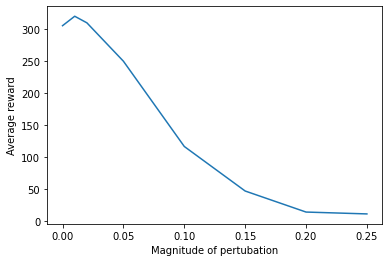

In [16]:
epsilons_attacks = [0,0.01,0.02,0.05,0.10,0.15,0.20,0.25]
plt.ioff()
plt.figure(1)
plt.plot(epsilons_attacks,average_reward_number_attacked)
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.show()

## Training with adversarial training (only run if you want to train again)

In [5]:
def train_robust(agent_robust, EPSILON_PERT):
    agent_robust.network.train()

    best_reward = 0
    average_reward = 0
    episode_number = []
    average_reward_number = []


    for i in range(1, EPISODES):
        state = env.reset()
        score = 0
        while True:
            pert_state = attack_FGSM(state, EPSILON_PERT, agent_robust)
            action, q_values = agent_robust.choose_action(pert_state)
            state_, reward, done, info = env.step(action)


            agent_robust.memory.add(state, action, reward, state_, done)
            agent_robust.learn()
            state = state_
            score += reward

            if done:
                if score > best_reward:
                    best_reward = score
                average_reward += score
                print("Episode {} Average Reward {} Best Reward {} Last Reward {} Epsilon {}".format(i, average_reward/i, best_reward, score, agent.returning_epsilon()))
                break

            episode_number.append(i)
            average_reward_number.append(average_reward/i)

In [6]:
robust_agent_1 = DQN_Solver()
robust_agent_2 = DQN_Solver()
robust_agent_3 = DQN_Solver()
robust_agent_4 = DQN_Solver()

agents = [[robust_agent_1,0.01],[robust_agent_2, 0.02], [robust_agent_3, 0.05], [robust_agent_4, 0.10]]
for agent, eps in agents:
    print("NOW TRAINING AGENT WITH EPS:", eps)
    train_robust(agent, eps)

/tmp/ipykernel_267/1353702249.py:29: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.dones = np.zeros(MEM_SIZE, dtype=np.bool)


NOW TRAINING AGENT WITH EPS: 0.01
Episode 1 Average Reward 9.0 Best Reward 9.0 Last Reward 9.0 Epsilon 1.0
Episode 2 Average Reward 20.0 Best Reward 31.0 Last Reward 31.0 Epsilon 0.9910359161258742
Episode 3 Average Reward 21.333333333333332 Best Reward 31.0 Last Reward 24.0 Epsilon 0.9675225846837673
Episode 4 Average Reward 22.5 Best Reward 31.0 Last Reward 26.0 Epsilon 0.9426789411643326
Episode 5 Average Reward 27.2 Best Reward 46.0 Last Reward 46.0 Epsilon 0.9002772252562138
Episode 6 Average Reward 25.833333333333332 Best Reward 46.0 Last Reward 19.0 Epsilon 0.8833250364922639
Episode 7 Average Reward 23.428571428571427 Best Reward 46.0 Last Reward 9.0 Epsilon 0.8754068367770318
Episode 8 Average Reward 22.5 Best Reward 46.0 Last Reward 16.0 Epsilon 0.8615048875706075
Episode 9 Average Reward 22.555555555555557 Best Reward 46.0 Last Reward 23.0 Epsilon 0.8419067177676068
Episode 10 Average Reward 21.8 Best Reward 46.0 Last Reward 15.0 Epsilon 0.8293661352855802
Episode 11 Average

Episode 82 Average Reward 141.84146341463415 Best Reward 500.0 Last Reward 264.0 Epsilon 0.001
Episode 83 Average Reward 142.89156626506025 Best Reward 500.0 Last Reward 229.0 Epsilon 0.001
Episode 84 Average Reward 144.3452380952381 Best Reward 500.0 Last Reward 265.0 Epsilon 0.001
Episode 85 Average Reward 146.25882352941176 Best Reward 500.0 Last Reward 307.0 Epsilon 0.001
Episode 86 Average Reward 148.2093023255814 Best Reward 500.0 Last Reward 314.0 Epsilon 0.001
Episode 87 Average Reward 150.32183908045977 Best Reward 500.0 Last Reward 332.0 Epsilon 0.001
Episode 88 Average Reward 153.4431818181818 Best Reward 500.0 Last Reward 425.0 Epsilon 0.001
Episode 89 Average Reward 156.14606741573033 Best Reward 500.0 Last Reward 394.0 Epsilon 0.001
Episode 90 Average Reward 158.32222222222222 Best Reward 500.0 Last Reward 352.0 Epsilon 0.001
Episode 91 Average Reward 160.82417582417582 Best Reward 500.0 Last Reward 386.0 Epsilon 0.001
Episode 92 Average Reward 162.6195652173913 Best Rewa

Episode 169 Average Reward 222.40828402366864 Best Reward 500.0 Last Reward 258.0 Epsilon 0.001
Episode 170 Average Reward 222.40588235294118 Best Reward 500.0 Last Reward 222.0 Epsilon 0.001
Episode 171 Average Reward 222.7017543859649 Best Reward 500.0 Last Reward 273.0 Epsilon 0.001
Episode 172 Average Reward 222.88953488372093 Best Reward 500.0 Last Reward 255.0 Epsilon 0.001
Episode 173 Average Reward 223.11560693641619 Best Reward 500.0 Last Reward 262.0 Epsilon 0.001
Episode 174 Average Reward 223.22988505747125 Best Reward 500.0 Last Reward 243.0 Epsilon 0.001
Episode 175 Average Reward 223.4857142857143 Best Reward 500.0 Last Reward 268.0 Epsilon 0.001
Episode 176 Average Reward 223.79545454545453 Best Reward 500.0 Last Reward 278.0 Epsilon 0.001
Episode 177 Average Reward 223.92090395480227 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 178 Average Reward 224.1123595505618 Best Reward 500.0 Last Reward 258.0 Epsilon 0.001
Episode 179 Average Reward 224.296089385474

Episode 255 Average Reward 226.45098039215685 Best Reward 500.0 Last Reward 172.0 Epsilon 0.001
Episode 256 Average Reward 226.51953125 Best Reward 500.0 Last Reward 244.0 Epsilon 0.001
Episode 257 Average Reward 226.284046692607 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 258 Average Reward 226.01937984496124 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 259 Average Reward 225.73359073359075 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 260 Average Reward 225.76538461538462 Best Reward 500.0 Last Reward 234.0 Epsilon 0.001
Episode 261 Average Reward 225.7471264367816 Best Reward 500.0 Last Reward 221.0 Epsilon 0.001
Episode 262 Average Reward 225.72519083969465 Best Reward 500.0 Last Reward 220.0 Epsilon 0.001
Episode 263 Average Reward 225.76425855513307 Best Reward 500.0 Last Reward 236.0 Epsilon 0.001
Episode 264 Average Reward 226.29166666666666 Best Reward 500.0 Last Reward 365.0 Epsilon 0.001
Episode 265 Average Reward 226.10943396226415 Bes

Episode 342 Average Reward 249.8859649122807 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 343 Average Reward 250.47813411078718 Best Reward 500.0 Last Reward 453.0 Epsilon 0.001
Episode 344 Average Reward 251.20348837209303 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 345 Average Reward 251.92463768115942 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 346 Average Reward 252.64161849710982 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 347 Average Reward 253.35446685878964 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 348 Average Reward 254.0632183908046 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 349 Average Reward 254.76790830945558 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 350 Average Reward 255.46857142857144 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 351 Average Reward 256.16524216524215 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 352 Average Reward 256.85795454545

Episode 429 Average Reward 278.86713286713285 Best Reward 500.0 Last Reward 154.0 Epsilon 0.001
Episode 430 Average Reward 278.80930232558137 Best Reward 500.0 Last Reward 254.0 Epsilon 0.001
Episode 431 Average Reward 279.17401392111367 Best Reward 500.0 Last Reward 436.0 Epsilon 0.001
Episode 432 Average Reward 279.4074074074074 Best Reward 500.0 Last Reward 380.0 Epsilon 0.001
Episode 433 Average Reward 279.6674364896074 Best Reward 500.0 Last Reward 392.0 Epsilon 0.001
Episode 434 Average Reward 279.4193548387097 Best Reward 500.0 Last Reward 172.0 Epsilon 0.001
Episode 435 Average Reward 279.15402298850574 Best Reward 500.0 Last Reward 164.0 Epsilon 0.001
Episode 436 Average Reward 279.1215596330275 Best Reward 500.0 Last Reward 265.0 Epsilon 0.001
Episode 437 Average Reward 279.0228832951945 Best Reward 500.0 Last Reward 236.0 Epsilon 0.001
Episode 438 Average Reward 279.2716894977169 Best Reward 500.0 Last Reward 388.0 Epsilon 0.001
Episode 439 Average Reward 279.2391799544419 B

Episode 17 Average Reward 24.529411764705884 Best Reward 49.0 Last Reward 32.0 Epsilon 0.6796392551158754
Episode 18 Average Reward 28.333333333333332 Best Reward 93.0 Last Reward 93.0 Epsilon 0.6192540566123834
Episode 19 Average Reward 29.05263157894737 Best Reward 93.0 Last Reward 42.0 Epsilon 0.5937715237303958
Episode 20 Average Reward 28.8 Best Reward 93.0 Last Reward 24.0 Epsilon 0.57968369259211
Episode 21 Average Reward 31.333333333333332 Best Reward 93.0 Last Reward 82.0 Epsilon 0.534024420840334
Episode 22 Average Reward 36.18181818181818 Best Reward 138.0 Last Reward 138.0 Epsilon 0.46515585607821586
Episode 23 Average Reward 39.73913043478261 Best Reward 138.0 Last Reward 118.0 Epsilon 0.4133577680476022
Episode 24 Average Reward 45.25 Best Reward 172.0 Last Reward 172.0 Epsilon 0.3480086817607007
Episode 25 Average Reward 47.36 Best Reward 172.0 Last Reward 98.0 Epsilon 0.3155062193168902
Episode 26 Average Reward 50.88461538461539 Best Reward 172.0 Last Reward 139.0 Epsi

Episode 102 Average Reward 203.0 Best Reward 457.0 Last Reward 457.0 Epsilon 0.001
Episode 103 Average Reward 204.23300970873785 Best Reward 457.0 Last Reward 330.0 Epsilon 0.001
Episode 104 Average Reward 203.93269230769232 Best Reward 457.0 Last Reward 173.0 Epsilon 0.001
Episode 105 Average Reward 203.58095238095237 Best Reward 457.0 Last Reward 167.0 Epsilon 0.001
Episode 106 Average Reward 202.8490566037736 Best Reward 457.0 Last Reward 126.0 Epsilon 0.001
Episode 107 Average Reward 205.34579439252337 Best Reward 470.0 Last Reward 470.0 Epsilon 0.001
Episode 108 Average Reward 204.77777777777777 Best Reward 470.0 Last Reward 144.0 Epsilon 0.001
Episode 109 Average Reward 204.11926605504587 Best Reward 470.0 Last Reward 133.0 Epsilon 0.001
Episode 110 Average Reward 203.64545454545456 Best Reward 470.0 Last Reward 152.0 Epsilon 0.001
Episode 111 Average Reward 203.11711711711712 Best Reward 470.0 Last Reward 145.0 Epsilon 0.001
Episode 112 Average Reward 202.64285714285714 Best Rew

Episode 189 Average Reward 208.34391534391534 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 190 Average Reward 207.32631578947368 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 191 Average Reward 207.14659685863873 Best Reward 500.0 Last Reward 173.0 Epsilon 0.001
Episode 192 Average Reward 207.08333333333334 Best Reward 500.0 Last Reward 195.0 Epsilon 0.001
Episode 193 Average Reward 207.1865284974093 Best Reward 500.0 Last Reward 227.0 Epsilon 0.001
Episode 194 Average Reward 207.05670103092783 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 195 Average Reward 207.54358974358973 Best Reward 500.0 Last Reward 302.0 Epsilon 0.001
Episode 196 Average Reward 208.76020408163265 Best Reward 500.0 Last Reward 446.0 Epsilon 0.001
Episode 197 Average Reward 210.23857868020303 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 198 Average Reward 211.22222222222223 Best Reward 500.0 Last Reward 405.0 Epsilon 0.001
Episode 199 Average Reward 212.673366834170

Episode 276 Average Reward 240.57246376811594 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 277 Average Reward 240.0974729241877 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 278 Average Reward 239.81654676258992 Best Reward 500.0 Last Reward 162.0 Epsilon 0.001
Episode 279 Average Reward 239.5627240143369 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 280 Average Reward 239.18571428571428 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 281 Average Reward 238.90391459074732 Best Reward 500.0 Last Reward 160.0 Epsilon 0.001
Episode 282 Average Reward 238.67375886524823 Best Reward 500.0 Last Reward 174.0 Epsilon 0.001
Episode 283 Average Reward 238.3957597173145 Best Reward 500.0 Last Reward 160.0 Epsilon 0.001
Episode 284 Average Reward 239.14788732394365 Best Reward 500.0 Last Reward 452.0 Epsilon 0.001
Episode 285 Average Reward 239.63508771929824 Best Reward 500.0 Last Reward 378.0 Epsilon 0.001
Episode 286 Average Reward 239.856643356643

Episode 363 Average Reward 245.40495867768595 Best Reward 500.0 Last Reward 450.0 Epsilon 0.001
Episode 364 Average Reward 245.26923076923077 Best Reward 500.0 Last Reward 196.0 Epsilon 0.001
Episode 365 Average Reward 245.96712328767123 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 366 Average Reward 245.9207650273224 Best Reward 500.0 Last Reward 229.0 Epsilon 0.001
Episode 367 Average Reward 245.6485013623978 Best Reward 500.0 Last Reward 146.0 Epsilon 0.001
Episode 368 Average Reward 245.41847826086956 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 369 Average Reward 245.1219512195122 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 370 Average Reward 244.97297297297297 Best Reward 500.0 Last Reward 190.0 Epsilon 0.001
Episode 371 Average Reward 244.90835579514825 Best Reward 500.0 Last Reward 221.0 Epsilon 0.001
Episode 372 Average Reward 244.74462365591398 Best Reward 500.0 Last Reward 184.0 Epsilon 0.001
Episode 373 Average Reward 244.477211796246

Episode 449 Average Reward 247.23608017817372 Best Reward 500.0 Last Reward 324.0 Epsilon 0.001
Episode 450 Average Reward 247.55777777777777 Best Reward 500.0 Last Reward 392.0 Epsilon 0.001
Episode 451 Average Reward 247.68736141906874 Best Reward 500.0 Last Reward 306.0 Epsilon 0.001
Episode 452 Average Reward 248.24557522123894 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 453 Average Reward 248.4569536423841 Best Reward 500.0 Last Reward 344.0 Epsilon 0.001
Episode 454 Average Reward 249.01101321585904 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 455 Average Reward 249.1912087912088 Best Reward 500.0 Last Reward 331.0 Epsilon 0.001
Episode 456 Average Reward 249.42763157894737 Best Reward 500.0 Last Reward 357.0 Epsilon 0.001
Episode 457 Average Reward 249.89277899343546 Best Reward 500.0 Last Reward 462.0 Epsilon 0.001
Episode 458 Average Reward 249.8886462882096 Best Reward 500.0 Last Reward 248.0 Epsilon 0.001
Episode 459 Average Reward 249.662309368191

Episode 34 Average Reward 19.11764705882353 Best Reward 74.0 Last Reward 17.0 Epsilon 0.5383159053457894
Episode 35 Average Reward 19.085714285714285 Best Reward 74.0 Last Reward 18.0 Epsilon 0.5287081437599487
Episode 36 Average Reward 18.97222222222222 Best Reward 74.0 Last Reward 15.0 Epsilon 0.5208327961165404
Episode 37 Average Reward 18.945945945945947 Best Reward 74.0 Last Reward 18.0 Epsilon 0.5115370697939825
Episode 38 Average Reward 19.894736842105264 Best Reward 74.0 Last Reward 55.0 Epsilon 0.4841489160264175
Episode 39 Average Reward 20.897435897435898 Best Reward 74.0 Last Reward 59.0 Epsilon 0.4563969875256424
Episode 40 Average Reward 22.3 Best Reward 77.0 Last Reward 77.0 Epsilon 0.42255706035237733
Episode 41 Average Reward 23.073170731707318 Best Reward 77.0 Last Reward 54.0 Epsilon 0.40033330944997925
Episode 42 Average Reward 24.0 Best Reward 77.0 Last Reward 62.0 Epsilon 0.37625475470427916
Episode 43 Average Reward 23.953488372093023 Best Reward 77.0 Last Reward

Episode 116 Average Reward 152.61206896551724 Best Reward 500.0 Last Reward 349.0 Epsilon 0.001
Episode 117 Average Reward 153.25641025641025 Best Reward 500.0 Last Reward 228.0 Epsilon 0.001
Episode 118 Average Reward 153.26271186440678 Best Reward 500.0 Last Reward 154.0 Epsilon 0.001
Episode 119 Average Reward 153.46218487394958 Best Reward 500.0 Last Reward 177.0 Epsilon 0.001
Episode 120 Average Reward 153.80833333333334 Best Reward 500.0 Last Reward 195.0 Epsilon 0.001
Episode 121 Average Reward 154.21487603305786 Best Reward 500.0 Last Reward 203.0 Epsilon 0.001
Episode 122 Average Reward 154.45081967213116 Best Reward 500.0 Last Reward 183.0 Epsilon 0.001
Episode 123 Average Reward 155.54471544715446 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
Episode 124 Average Reward 155.99193548387098 Best Reward 500.0 Last Reward 211.0 Epsilon 0.001
Episode 125 Average Reward 155.976 Best Reward 500.0 Last Reward 154.0 Epsilon 0.001
Episode 126 Average Reward 156.47619047619048 Best 

Episode 203 Average Reward 191.064039408867 Best Reward 500.0 Last Reward 227.0 Epsilon 0.001
Episode 204 Average Reward 192.01470588235293 Best Reward 500.0 Last Reward 385.0 Epsilon 0.001
Episode 205 Average Reward 191.72682926829268 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 206 Average Reward 192.14563106796118 Best Reward 500.0 Last Reward 278.0 Epsilon 0.001
Episode 207 Average Reward 192.64734299516908 Best Reward 500.0 Last Reward 296.0 Epsilon 0.001
Episode 208 Average Reward 193.59134615384616 Best Reward 500.0 Last Reward 389.0 Epsilon 0.001
Episode 209 Average Reward 193.4354066985646 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 210 Average Reward 194.5047619047619 Best Reward 500.0 Last Reward 418.0 Epsilon 0.001
Episode 211 Average Reward 195.08056872037915 Best Reward 500.0 Last Reward 316.0 Epsilon 0.001
Episode 212 Average Reward 196.4009433962264 Best Reward 500.0 Last Reward 475.0 Epsilon 0.001
Episode 213 Average Reward 196.7699530516432 

Episode 289 Average Reward 196.95501730103805 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 290 Average Reward 196.30344827586208 Best Reward 500.0 Last Reward 8.0 Epsilon 0.001
Episode 291 Average Reward 195.66666666666666 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 292 Average Reward 195.03082191780823 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 293 Average Reward 194.40273037542661 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 294 Average Reward 193.77551020408163 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 295 Average Reward 193.15593220338982 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 296 Average Reward 192.5641891891892 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 297 Average Reward 192.1077441077441 Best Reward 500.0 Last Reward 57.0 Epsilon 0.001
Episode 298 Average Reward 191.83557046979865 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 299 Average Reward 191.8227424749164 Best R

Episode 376 Average Reward 185.31382978723406 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 377 Average Reward 185.15649867374006 Best Reward 500.0 Last Reward 126.0 Epsilon 0.001
Episode 378 Average Reward 184.984126984127 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 379 Average Reward 184.8126649076517 Best Reward 500.0 Last Reward 120.0 Epsilon 0.001
Episode 380 Average Reward 184.62894736842105 Best Reward 500.0 Last Reward 115.0 Epsilon 0.001
Episode 381 Average Reward 184.48818897637796 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 382 Average Reward 184.5 Best Reward 500.0 Last Reward 189.0 Epsilon 0.001
Episode 383 Average Reward 184.3028720626632 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 384 Average Reward 184.24479166666666 Best Reward 500.0 Last Reward 162.0 Epsilon 0.001
Episode 385 Average Reward 184.06233766233765 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 386 Average Reward 183.84455958549222 Best Reward

Episode 463 Average Reward 168.94816414686824 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 464 Average Reward 168.85129310344828 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 465 Average Reward 168.7225806451613 Best Reward 500.0 Last Reward 109.0 Epsilon 0.001
Episode 466 Average Reward 168.59012875536482 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 467 Average Reward 168.54603854389723 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 468 Average Reward 168.39957264957266 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 469 Average Reward 168.28997867803838 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 470 Average Reward 168.15531914893617 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 471 Average Reward 168.0764331210191 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 472 Average Reward 167.96822033898306 Best Reward 500.0 Last Reward 117.0 Epsilon 0.001
Episode 473 Average Reward 167.83932346723

Episode 47 Average Reward 47.276595744680854 Best Reward 170.0 Last Reward 108.0 Epsilon 0.1116823909923804
Episode 48 Average Reward 48.541666666666664 Best Reward 170.0 Last Reward 108.0 Epsilon 0.100243779268176
Episode 49 Average Reward 50.57142857142857 Best Reward 170.0 Last Reward 148.0 Epsilon 0.08644695274082355
Episode 50 Average Reward 52.4 Best Reward 170.0 Last Reward 142.0 Epsilon 0.07499788516467158
Episode 51 Average Reward 54.84313725490196 Best Reward 177.0 Last Reward 177.0 Epsilon 0.0628261480029449
Episode 52 Average Reward 58.38461538461539 Best Reward 239.0 Last Reward 239.0 Epsilon 0.04946432865511062
Episode 53 Average Reward 62.905660377358494 Best Reward 298.0 Last Reward 298.0 Epsilon 0.03671196329033828
Episode 54 Average Reward 67.74074074074075 Best Reward 324.0 Last Reward 324.0 Epsilon 0.02654763241338782
Episode 55 Average Reward 69.01818181818182 Best Reward 324.0 Last Reward 138.0 Epsilon 0.02312401118785413
Episode 56 Average Reward 69.875 Best Rewa

Episode 130 Average Reward 93.84615384615384 Best Reward 324.0 Last Reward 109.0 Epsilon 0.001
Episode 131 Average Reward 94.10687022900764 Best Reward 324.0 Last Reward 128.0 Epsilon 0.001
Episode 132 Average Reward 94.01515151515152 Best Reward 324.0 Last Reward 82.0 Epsilon 0.001
Episode 133 Average Reward 94.0827067669173 Best Reward 324.0 Last Reward 103.0 Epsilon 0.001
Episode 134 Average Reward 94.02985074626865 Best Reward 324.0 Last Reward 87.0 Epsilon 0.001
Episode 135 Average Reward 93.97037037037038 Best Reward 324.0 Last Reward 86.0 Epsilon 0.001
Episode 136 Average Reward 93.7279411764706 Best Reward 324.0 Last Reward 61.0 Epsilon 0.001
Episode 137 Average Reward 93.5912408759124 Best Reward 324.0 Last Reward 75.0 Epsilon 0.001
Episode 138 Average Reward 93.55072463768116 Best Reward 324.0 Last Reward 88.0 Epsilon 0.001
Episode 139 Average Reward 93.70503597122303 Best Reward 324.0 Last Reward 115.0 Epsilon 0.001
Episode 140 Average Reward 93.5 Best Reward 324.0 Last Rewa

Episode 217 Average Reward 104.15668202764977 Best Reward 448.0 Last Reward 110.0 Epsilon 0.001
Episode 218 Average Reward 104.1559633027523 Best Reward 448.0 Last Reward 104.0 Epsilon 0.001
Episode 219 Average Reward 104.45662100456622 Best Reward 448.0 Last Reward 170.0 Epsilon 0.001
Episode 220 Average Reward 104.69545454545455 Best Reward 448.0 Last Reward 157.0 Epsilon 0.001
Episode 221 Average Reward 105.08144796380091 Best Reward 448.0 Last Reward 190.0 Epsilon 0.001
Episode 222 Average Reward 105.05405405405405 Best Reward 448.0 Last Reward 99.0 Epsilon 0.001
Episode 223 Average Reward 104.95515695067265 Best Reward 448.0 Last Reward 83.0 Epsilon 0.001
Episode 224 Average Reward 104.91517857142857 Best Reward 448.0 Last Reward 96.0 Epsilon 0.001
Episode 225 Average Reward 105.12 Best Reward 448.0 Last Reward 151.0 Epsilon 0.001
Episode 226 Average Reward 105.19026548672566 Best Reward 448.0 Last Reward 121.0 Epsilon 0.001
Episode 227 Average Reward 105.26872246696036 Best Rewar

Episode 304 Average Reward 101.09210526315789 Best Reward 448.0 Last Reward 93.0 Epsilon 0.001
Episode 305 Average Reward 101.09836065573771 Best Reward 448.0 Last Reward 103.0 Epsilon 0.001
Episode 306 Average Reward 101.07516339869281 Best Reward 448.0 Last Reward 94.0 Epsilon 0.001
Episode 307 Average Reward 100.90228013029316 Best Reward 448.0 Last Reward 48.0 Epsilon 0.001
Episode 308 Average Reward 100.93181818181819 Best Reward 448.0 Last Reward 110.0 Epsilon 0.001
Episode 309 Average Reward 100.79611650485437 Best Reward 448.0 Last Reward 59.0 Epsilon 0.001
Episode 310 Average Reward 100.53225806451613 Best Reward 448.0 Last Reward 19.0 Epsilon 0.001
Episode 311 Average Reward 100.43729903536978 Best Reward 448.0 Last Reward 71.0 Epsilon 0.001
Episode 312 Average Reward 100.31089743589743 Best Reward 448.0 Last Reward 61.0 Epsilon 0.001
Episode 313 Average Reward 100.40255591054313 Best Reward 448.0 Last Reward 129.0 Epsilon 0.001
Episode 314 Average Reward 100.31847133757962 B

Episode 391 Average Reward 100.41432225063939 Best Reward 448.0 Last Reward 109.0 Epsilon 0.001
Episode 392 Average Reward 100.28826530612245 Best Reward 448.0 Last Reward 51.0 Epsilon 0.001
Episode 393 Average Reward 100.30788804071247 Best Reward 448.0 Last Reward 108.0 Epsilon 0.001
Episode 394 Average Reward 100.36548223350253 Best Reward 448.0 Last Reward 123.0 Epsilon 0.001
Episode 395 Average Reward 100.18987341772151 Best Reward 448.0 Last Reward 31.0 Epsilon 0.001
Episode 396 Average Reward 100.27020202020202 Best Reward 448.0 Last Reward 132.0 Epsilon 0.001
Episode 397 Average Reward 100.29722921914357 Best Reward 448.0 Last Reward 111.0 Epsilon 0.001
Episode 398 Average Reward 100.33417085427136 Best Reward 448.0 Last Reward 115.0 Epsilon 0.001
Episode 399 Average Reward 100.36842105263158 Best Reward 448.0 Last Reward 114.0 Epsilon 0.001
Episode 400 Average Reward 100.355 Best Reward 448.0 Last Reward 95.0 Epsilon 0.001
Episode 401 Average Reward 100.24189526184539 Best Rew

Episode 479 Average Reward 95.2964509394572 Best Reward 448.0 Last Reward 114.0 Epsilon 0.001
Episode 480 Average Reward 95.21041666666666 Best Reward 448.0 Last Reward 54.0 Epsilon 0.001
Episode 481 Average Reward 95.22869022869023 Best Reward 448.0 Last Reward 104.0 Epsilon 0.001
Episode 482 Average Reward 95.25726141078839 Best Reward 448.0 Last Reward 109.0 Epsilon 0.001
Episode 483 Average Reward 95.2919254658385 Best Reward 448.0 Last Reward 112.0 Epsilon 0.001
Episode 484 Average Reward 95.28512396694215 Best Reward 448.0 Last Reward 92.0 Epsilon 0.001
Episode 485 Average Reward 95.21030927835052 Best Reward 448.0 Last Reward 59.0 Epsilon 0.001
Episode 486 Average Reward 95.23045267489712 Best Reward 448.0 Last Reward 105.0 Epsilon 0.001
Episode 487 Average Reward 95.25872689938399 Best Reward 448.0 Last Reward 109.0 Epsilon 0.001
Episode 488 Average Reward 95.34016393442623 Best Reward 448.0 Last Reward 135.0 Epsilon 0.001
Episode 489 Average Reward 95.35378323108384 Best Rewar

In [7]:
torch.save(robust_agent_1, "robust_trained_DQN1.pth")
torch.save(robust_agent_2, "robust_trained_DQN2.pth")
torch.save(robust_agent_3, "robust_trained_DQN3.pth")
torch.save(robust_agent_4, "robust_trained_DQN4.pth")

## Testing robust network

In [17]:
robust_agent_1 = torch.load("robust_trained_DQN1.pth")
robust_agent_2 = torch.load("robust_trained_DQN2.pth")
robust_agent_3 = torch.load("robust_trained_DQN3.pth")
robust_agent_4 = torch.load("robust_trained_DQN4.pth")


In [18]:
robust_agents = [robust_agent_1, robust_agent_2,robust_agent_3,robust_agent_4]
robust_average_rewards = []
for agent in robust_agents:
    print("The current agent is", agent)
    average_rewards = test_network(agent)
    robust_average_rewards.append(average_rewards)

NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0
Episode 1 Average Reward 486.0 Best Reward 486.0 Last Reward 486.0 Epsilon 0.001
Episode 2 Average Reward 430.0 Best Reward 486.0 Last Reward 374.0 Epsilon 0.001
Episode 3 Average Reward 378.6666666666667 Best Reward 486.0 Last Reward 276.0 Epsilon 0.001
Episode 4 Average Reward 409.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 5 Average Reward 377.0 Best Reward 500.0 Last Reward 249.0 Epsilon 0.001
Episode 6 Average Reward 361.8333333333333 Best Reward 500.0 Last Reward 286.0 Epsilon 0.001
Episode 7 Average Reward 381.57142857142856 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 8 Average Reward 377.25 Best Reward 500.0 Last Reward 347.0 Epsilon 0.001
Episode 9 Average Reward 390.8888888888889 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 10 Average Reward 378.7 Best Reward 500.0 Last Reward 269.0 Epsilon 0.001
Episode 11 Average Reward 366.0 Best Reward 500.0 Last Reward 239.0 Epsilon 0.001
Episode 12

Episode 90 Average Reward 405.24444444444447 Best Reward 500.0 Last Reward 286.0 Epsilon 0.001
Episode 91 Average Reward 405.5164835164835 Best Reward 500.0 Last Reward 430.0 Epsilon 0.001
Episode 92 Average Reward 404.8478260869565 Best Reward 500.0 Last Reward 344.0 Epsilon 0.001
Episode 93 Average Reward 405.8709677419355 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 94 Average Reward 405.0 Best Reward 500.0 Last Reward 324.0 Epsilon 0.001
Episode 95 Average Reward 404.3263157894737 Best Reward 500.0 Last Reward 341.0 Epsilon 0.001
Episode 96 Average Reward 404.15625 Best Reward 500.0 Last Reward 388.0 Epsilon 0.001
Episode 97 Average Reward 403.319587628866 Best Reward 500.0 Last Reward 323.0 Epsilon 0.001
Episode 98 Average Reward 403.2448979591837 Best Reward 500.0 Last Reward 396.0 Epsilon 0.001
Episode 99 Average Reward 402.42424242424244 Best Reward 500.0 Last Reward 322.0 Epsilon 0.001
Episode 100 Average Reward 403.4 Best Reward 500.0 Last Reward 500.0 Epsilon 0.

Episode 177 Average Reward 406.5875706214689 Best Reward 500.0 Last Reward 289.0 Epsilon 0.001
Episode 178 Average Reward 407.1123595505618 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 179 Average Reward 407.14525139664806 Best Reward 500.0 Last Reward 413.0 Epsilon 0.001
Episode 180 Average Reward 407.2888888888889 Best Reward 500.0 Last Reward 433.0 Epsilon 0.001
Episode 181 Average Reward 407.3867403314917 Best Reward 500.0 Last Reward 425.0 Epsilon 0.001
Episode 182 Average Reward 407.8956043956044 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 183 Average Reward 407.69398907103823 Best Reward 500.0 Last Reward 371.0 Epsilon 0.001
Episode 184 Average Reward 408.10869565217394 Best Reward 500.0 Last Reward 484.0 Epsilon 0.001
Episode 185 Average Reward 408.6054054054054 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 186 Average Reward 408.505376344086 Best Reward 500.0 Last Reward 390.0 Epsilon 0.001
Episode 187 Average Reward 408.9946524064171 Bes

Episode 16 Average Reward 419.8125 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 17 Average Reward 414.4117647058824 Best Reward 500.0 Last Reward 328.0 Epsilon 0.001
Episode 18 Average Reward 419.1666666666667 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 19 Average Reward 423.42105263157896 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 20 Average Reward 427.25 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 21 Average Reward 430.7142857142857 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 22 Average Reward 433.8636363636364 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 23 Average Reward 429.1304347826087 Best Reward 500.0 Last Reward 325.0 Epsilon 0.001
Episode 24 Average Reward 432.0833333333333 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 25 Average Reward 434.8 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 26 Average Reward 437.3076923076923 Best Reward 500.0 Last Reward 500.0 Epsilon 0.0

Episode 105 Average Reward 439.752380952381 Best Reward 500.0 Last Reward 299.0 Epsilon 0.001
Episode 106 Average Reward 439.74528301886795 Best Reward 500.0 Last Reward 439.0 Epsilon 0.001
Episode 107 Average Reward 440.14953271028037 Best Reward 500.0 Last Reward 483.0 Epsilon 0.001
Episode 108 Average Reward 440.7037037037037 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 109 Average Reward 441.2477064220183 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 110 Average Reward 441.7818181818182 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 111 Average Reward 442.3063063063063 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 112 Average Reward 442.82142857142856 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 113 Average Reward 443.3274336283186 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 114 Average Reward 442.4824561403509 Best Reward 500.0 Last Reward 347.0 Epsilon 0.001
Episode 115 Average Reward 441.7130434782609 Bes

Episode 192 Average Reward 426.4114583333333 Best Reward 500.0 Last Reward 251.0 Epsilon 0.001
Episode 193 Average Reward 426.79274611398966 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 194 Average Reward 427.1701030927835 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 195 Average Reward 426.54358974358973 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 196 Average Reward 425.8775510204082 Best Reward 500.0 Last Reward 296.0 Epsilon 0.001
Episode 197 Average Reward 426.25380710659897 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 198 Average Reward 426.62626262626264 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 199 Average Reward 426.0150753768844 Best Reward 500.0 Last Reward 305.0 Epsilon 0.001
Episode 200 Average Reward 425.3 Best Reward 500.0 Last Reward 283.0 Epsilon 0.001
Episode 201 Average Reward 424.50248756218906 Best Reward 500.0 Last Reward 265.0 Epsilon 0.001
Episode 202 Average Reward 423.9306930693069 Best Reward 

Episode 31 Average Reward 452.06451612903226 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 32 Average Reward 453.5625 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 33 Average Reward 454.969696969697 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 34 Average Reward 456.29411764705884 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 35 Average Reward 457.54285714285714 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 36 Average Reward 458.72222222222223 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 37 Average Reward 459.8378378378378 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 38 Average Reward 460.89473684210526 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 39 Average Reward 461.8974358974359 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 40 Average Reward 462.85 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 41 Average Reward 463.7560975609756 Best Reward 500.0 Last Reward 50

Episode 119 Average Reward 476.12605042016804 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 120 Average Reward 476.325 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 121 Average Reward 476.5206611570248 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 122 Average Reward 475.5 Best Reward 500.0 Last Reward 352.0 Epsilon 0.001
Episode 123 Average Reward 475.6991869918699 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 124 Average Reward 475.89516129032256 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 125 Average Reward 476.088 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 126 Average Reward 476.27777777777777 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 127 Average Reward 476.46456692913387 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 128 Average Reward 476.6484375 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 129 Average Reward 476.82945736434107 Best Reward 500.0 Last Reward 500.0 Ep

Episode 206 Average Reward 476.0728155339806 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 207 Average Reward 476.18840579710144 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 208 Average Reward 476.30288461538464 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 209 Average Reward 475.0047846889952 Best Reward 500.0 Last Reward 205.0 Epsilon 0.001
Episode 210 Average Reward 475.12380952380954 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 211 Average Reward 475.2417061611374 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 212 Average Reward 475.35849056603774 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 213 Average Reward 475.47417840375584 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 214 Average Reward 475.58878504672896 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 215 Average Reward 475.70232558139537 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 216 Average Reward 474.879629629629

Episode 45 Average Reward 373.24444444444447 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 46 Average Reward 376.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 47 Average Reward 372.36170212765956 Best Reward 500.0 Last Reward 205.0 Epsilon 0.001
Episode 48 Average Reward 371.2291666666667 Best Reward 500.0 Last Reward 318.0 Epsilon 0.001
Episode 49 Average Reward 369.40816326530614 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 50 Average Reward 366.08 Best Reward 500.0 Last Reward 203.0 Epsilon 0.001
Episode 51 Average Reward 365.80392156862746 Best Reward 500.0 Last Reward 352.0 Epsilon 0.001
Episode 52 Average Reward 366.28846153846155 Best Reward 500.0 Last Reward 391.0 Epsilon 0.001
Episode 53 Average Reward 363.92452830188677 Best Reward 500.0 Last Reward 241.0 Epsilon 0.001
Episode 54 Average Reward 366.35185185185185 Best Reward 500.0 Last Reward 495.0 Epsilon 0.001
Episode 55 Average Reward 365.7818181818182 Best Reward 500.0 Last Reward 33

Episode 133 Average Reward 363.49624060150376 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 134 Average Reward 363.2985074626866 Best Reward 500.0 Last Reward 337.0 Epsilon 0.001
Episode 135 Average Reward 362.4222222222222 Best Reward 500.0 Last Reward 245.0 Epsilon 0.001
Episode 136 Average Reward 363.43382352941177 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 137 Average Reward 364.43065693430657 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 138 Average Reward 363.5144927536232 Best Reward 500.0 Last Reward 238.0 Epsilon 0.001
Episode 139 Average Reward 361.8561151079137 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 140 Average Reward 362.84285714285716 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 141 Average Reward 363.8156028368794 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 142 Average Reward 363.3169014084507 Best Reward 500.0 Last Reward 293.0 Epsilon 0.001
Episode 143 Average Reward 362.6363636363636 B

Episode 220 Average Reward 358.5318181818182 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 221 Average Reward 359.17194570135746 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 222 Average Reward 359.8063063063063 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 223 Average Reward 359.33632286995515 Best Reward 500.0 Last Reward 255.0 Epsilon 0.001
Episode 224 Average Reward 359.9642857142857 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 225 Average Reward 358.97777777777776 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 226 Average Reward 358.87610619469024 Best Reward 500.0 Last Reward 336.0 Epsilon 0.001
Episode 227 Average Reward 359.4977973568282 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 228 Average Reward 360.1140350877193 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 229 Average Reward 360.29257641921396 Best Reward 500.0 Last Reward 401.0 Epsilon 0.001
Episode 230 Average Reward 359.2739130434783 

Episode 60 Average Reward 161.93333333333334 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 61 Average Reward 161.31147540983608 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 62 Average Reward 161.69354838709677 Best Reward 500.0 Last Reward 185.0 Epsilon 0.001
Episode 63 Average Reward 160.55555555555554 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 64 Average Reward 159.5625 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 65 Average Reward 159.41538461538462 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 66 Average Reward 158.45454545454547 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 67 Average Reward 157.4179104477612 Best Reward 500.0 Last Reward 89.0 Epsilon 0.001
Episode 68 Average Reward 157.7941176470588 Best Reward 500.0 Last Reward 183.0 Epsilon 0.001
Episode 69 Average Reward 156.7246376811594 Best Reward 500.0 Last Reward 84.0 Epsilon 0.001
Episode 70 Average Reward 155.7 Best Reward 500.0 Last Reward 85.0 E

Episode 148 Average Reward 159.72297297297297 Best Reward 500.0 Last Reward 205.0 Epsilon 0.001
Episode 149 Average Reward 159.88590604026845 Best Reward 500.0 Last Reward 184.0 Epsilon 0.001
Episode 150 Average Reward 160.06666666666666 Best Reward 500.0 Last Reward 187.0 Epsilon 0.001
Episode 151 Average Reward 159.58278145695365 Best Reward 500.0 Last Reward 87.0 Epsilon 0.001
Episode 152 Average Reward 159.14473684210526 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 153 Average Reward 159.01307189542484 Best Reward 500.0 Last Reward 139.0 Epsilon 0.001
Episode 154 Average Reward 159.33766233766235 Best Reward 500.0 Last Reward 209.0 Epsilon 0.001
Episode 155 Average Reward 159.56774193548387 Best Reward 500.0 Last Reward 195.0 Epsilon 0.001
Episode 156 Average Reward 159.7948717948718 Best Reward 500.0 Last Reward 195.0 Epsilon 0.001
Episode 157 Average Reward 159.3248407643312 Best Reward 500.0 Last Reward 86.0 Epsilon 0.001
Episode 158 Average Reward 158.85443037974684

Episode 235 Average Reward 156.10638297872342 Best Reward 500.0 Last Reward 190.0 Epsilon 0.001
Episode 236 Average Reward 156.02542372881356 Best Reward 500.0 Last Reward 137.0 Epsilon 0.001
Episode 237 Average Reward 156.16033755274262 Best Reward 500.0 Last Reward 188.0 Epsilon 0.001
Episode 238 Average Reward 156.41596638655463 Best Reward 500.0 Last Reward 217.0 Epsilon 0.001
Episode 239 Average Reward 156.55648535564853 Best Reward 500.0 Last Reward 190.0 Epsilon 0.001
Episode 240 Average Reward 156.7375 Best Reward 500.0 Last Reward 200.0 Epsilon 0.001
Episode 241 Average Reward 156.85892116182572 Best Reward 500.0 Last Reward 186.0 Epsilon 0.001
Episode 242 Average Reward 156.8099173553719 Best Reward 500.0 Last Reward 145.0 Epsilon 0.001
Episode 243 Average Reward 156.89711934156378 Best Reward 500.0 Last Reward 178.0 Epsilon 0.001
Episode 244 Average Reward 156.60245901639345 Best Reward 500.0 Last Reward 85.0 Epsilon 0.001
Episode 245 Average Reward 156.33061224489796 Best R

Episode 77 Average Reward 88.2987012987013 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 78 Average Reward 88.02564102564102 Best Reward 500.0 Last Reward 67.0 Epsilon 0.001
Episode 79 Average Reward 88.0886075949367 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 80 Average Reward 88.15 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 81 Average Reward 87.88888888888889 Best Reward 500.0 Last Reward 67.0 Epsilon 0.001
Episode 82 Average Reward 88.01219512195122 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 83 Average Reward 87.6867469879518 Best Reward 500.0 Last Reward 61.0 Epsilon 0.001
Episode 84 Average Reward 87.38095238095238 Best Reward 500.0 Last Reward 62.0 Epsilon 0.001
Episode 85 Average Reward 87.10588235294118 Best Reward 500.0 Last Reward 64.0 Epsilon 0.001
Episode 86 Average Reward 87.24418604651163 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 87 Average Reward 87.02298850574712 Best Reward 500.0 Last Reward 68.0 Epsil

Episode 167 Average Reward 88.89221556886227 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 168 Average Reward 88.96428571428571 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 169 Average Reward 88.99408284023669 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 170 Average Reward 89.03529411764706 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 171 Average Reward 89.09356725146199 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 172 Average Reward 89.13953488372093 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 173 Average Reward 89.01156069364161 Best Reward 500.0 Last Reward 67.0 Epsilon 0.001
Episode 174 Average Reward 89.08045977011494 Best Reward 500.0 Last Reward 101.0 Epsilon 0.001
Episode 175 Average Reward 89.13714285714286 Best Reward 500.0 Last Reward 99.0 Epsilon 0.001
Episode 176 Average Reward 89.00568181818181 Best Reward 500.0 Last Reward 66.0 Epsilon 0.001
Episode 177 Average Reward 89.045197740113 Best Reward 500

Episode 7 Average Reward 25.142857142857142 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 8 Average Reward 24.0 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 9 Average Reward 23.88888888888889 Best Reward 500.0 Last Reward 23.0 Epsilon 0.001
Episode 10 Average Reward 24.5 Best Reward 500.0 Last Reward 30.0 Epsilon 0.001
Episode 11 Average Reward 24.272727272727273 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 12 Average Reward 25.166666666666668 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 13 Average Reward 24.692307692307693 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 14 Average Reward 25.428571428571427 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 15 Average Reward 25.0 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 16 Average Reward 24.75 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 17 Average Reward 24.764705882352942 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 18 Average Reward

Episode 98 Average Reward 23.336734693877553 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 99 Average Reward 23.31313131313131 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 100 Average Reward 23.29 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 101 Average Reward 23.277227722772277 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 102 Average Reward 23.372549019607842 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 103 Average Reward 23.310679611650485 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 104 Average Reward 23.240384615384617 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 105 Average Reward 23.2 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 106 Average Reward 23.160377358490567 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 107 Average Reward 23.102803738317757 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 108 Average Reward 23.083333333333332 Best Reward 500.0 Last Reward 21.0

Episode 187 Average Reward 23.11764705882353 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 188 Average Reward 23.085106382978722 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 189 Average Reward 23.052910052910054 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 190 Average Reward 23.063157894736843 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 191 Average Reward 23.073298429319372 Best Reward 500.0 Last Reward 25.0 Epsilon 0.001
Episode 192 Average Reward 23.0625 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 193 Average Reward 23.124352331606218 Best Reward 500.0 Last Reward 35.0 Epsilon 0.001
Episode 194 Average Reward 23.128865979381445 Best Reward 500.0 Last Reward 24.0 Epsilon 0.001
Episode 195 Average Reward 23.102564102564102 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 196 Average Reward 23.122448979591837 Best Reward 500.0 Last Reward 27.0 Epsilon 0.001
Episode 197 Average Reward 23.091370558375633 Best Reward 500.

Episode 29 Average Reward 15.310344827586206 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 30 Average Reward 15.3 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 31 Average Reward 15.32258064516129 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 32 Average Reward 15.34375 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 33 Average Reward 15.363636363636363 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 34 Average Reward 15.382352941176471 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 35 Average Reward 15.4 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 36 Average Reward 15.472222222222221 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 37 Average Reward 15.432432432432432 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 38 Average Reward 15.394736842105264 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 39 Average Reward 15.35897435897436 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episod

Episode 121 Average Reward 15.198347107438016 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 122 Average Reward 15.180327868852459 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 123 Average Reward 15.170731707317072 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 124 Average Reward 15.161290322580646 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 125 Average Reward 15.16 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 126 Average Reward 15.174603174603174 Best Reward 500.0 Last Reward 17.0 Epsilon 0.001
Episode 127 Average Reward 15.173228346456693 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 128 Average Reward 15.1796875 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 129 Average Reward 15.170542635658915 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 130 Average Reward 15.153846153846153 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 131 Average Reward 15.16030534351145 Best Reward 500.0 Last Rew

Episode 214 Average Reward 15.130841121495328 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 215 Average Reward 15.134883720930233 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 216 Average Reward 15.13888888888889 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 217 Average Reward 15.138248847926267 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 218 Average Reward 15.123853211009175 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 219 Average Reward 15.123287671232877 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 220 Average Reward 15.127272727272727 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 221 Average Reward 15.122171945701357 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 222 Average Reward 15.117117117117116 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 223 Average Reward 15.112107623318385 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 224 Average Reward 15.116071428571429 Best 

Episode 54 Average Reward 364.4259259259259 Best Reward 500.0 Last Reward 328.0 Epsilon 0.001
Episode 55 Average Reward 364.8181818181818 Best Reward 500.0 Last Reward 386.0 Epsilon 0.001
Episode 56 Average Reward 364.2142857142857 Best Reward 500.0 Last Reward 331.0 Epsilon 0.001
Episode 57 Average Reward 364.2456140350877 Best Reward 500.0 Last Reward 366.0 Epsilon 0.001
Episode 58 Average Reward 365.17241379310343 Best Reward 500.0 Last Reward 418.0 Epsilon 0.001
Episode 59 Average Reward 365.79661016949154 Best Reward 500.0 Last Reward 402.0 Epsilon 0.001
Episode 60 Average Reward 365.8833333333333 Best Reward 500.0 Last Reward 371.0 Epsilon 0.001
Episode 61 Average Reward 366.44262295081967 Best Reward 500.0 Last Reward 400.0 Epsilon 0.001
Episode 62 Average Reward 367.06451612903226 Best Reward 500.0 Last Reward 405.0 Epsilon 0.001
Episode 63 Average Reward 366.58730158730157 Best Reward 500.0 Last Reward 337.0 Epsilon 0.001
Episode 64 Average Reward 367.046875 Best Reward 500.0 

Episode 142 Average Reward 367.38028169014086 Best Reward 500.0 Last Reward 447.0 Epsilon 0.001
Episode 143 Average Reward 367.16083916083915 Best Reward 500.0 Last Reward 336.0 Epsilon 0.001
Episode 144 Average Reward 366.6041666666667 Best Reward 500.0 Last Reward 287.0 Epsilon 0.001
Episode 145 Average Reward 366.88275862068963 Best Reward 500.0 Last Reward 407.0 Epsilon 0.001
Episode 146 Average Reward 366.78767123287673 Best Reward 500.0 Last Reward 353.0 Epsilon 0.001
Episode 147 Average Reward 367.16326530612247 Best Reward 500.0 Last Reward 422.0 Epsilon 0.001
Episode 148 Average Reward 366.94594594594594 Best Reward 500.0 Last Reward 335.0 Epsilon 0.001
Episode 149 Average Reward 366.19463087248323 Best Reward 500.0 Last Reward 255.0 Epsilon 0.001
Episode 150 Average Reward 366.3 Best Reward 500.0 Last Reward 382.0 Epsilon 0.001
Episode 151 Average Reward 366.2582781456954 Best Reward 500.0 Last Reward 360.0 Epsilon 0.001
Episode 152 Average Reward 366.17105263157896 Best Rewa

Episode 229 Average Reward 365.4541484716157 Best Reward 500.0 Last Reward 266.0 Epsilon 0.001
Episode 230 Average Reward 365.9695652173913 Best Reward 500.0 Last Reward 484.0 Epsilon 0.001
Episode 231 Average Reward 365.969696969697 Best Reward 500.0 Last Reward 366.0 Epsilon 0.001
Episode 232 Average Reward 365.8491379310345 Best Reward 500.0 Last Reward 338.0 Epsilon 0.001
Episode 233 Average Reward 365.6909871244635 Best Reward 500.0 Last Reward 329.0 Epsilon 0.001
Episode 234 Average Reward 365.8119658119658 Best Reward 500.0 Last Reward 394.0 Epsilon 0.001
Episode 235 Average Reward 366.11489361702127 Best Reward 500.0 Last Reward 437.0 Epsilon 0.001
Episode 236 Average Reward 366.5508474576271 Best Reward 500.0 Last Reward 469.0 Epsilon 0.001
Episode 237 Average Reward 366.53586497890296 Best Reward 500.0 Last Reward 363.0 Epsilon 0.001
Episode 238 Average Reward 366.42857142857144 Best Reward 500.0 Last Reward 341.0 Epsilon 0.001
Episode 239 Average Reward 366.3389121338912 Bes

Episode 69 Average Reward 382.18840579710144 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 70 Average Reward 383.87142857142857 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 71 Average Reward 382.40845070422534 Best Reward 500.0 Last Reward 280.0 Epsilon 0.001
Episode 72 Average Reward 384.0416666666667 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 73 Average Reward 385.63013698630135 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 74 Average Reward 387.1756756756757 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 75 Average Reward 388.68 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 76 Average Reward 386.67105263157896 Best Reward 500.0 Last Reward 236.0 Epsilon 0.001
Episode 77 Average Reward 388.14285714285717 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 78 Average Reward 389.5769230769231 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 79 Average Reward 387.53164556962025 Best Reward 500.0 La

Episode 157 Average Reward 383.4968152866242 Best Reward 500.0 Last Reward 213.0 Epsilon 0.001
Episode 158 Average Reward 384.23417721518985 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 159 Average Reward 383.2327044025157 Best Reward 500.0 Last Reward 225.0 Epsilon 0.001
Episode 160 Average Reward 382.15625 Best Reward 500.0 Last Reward 211.0 Epsilon 0.001
Episode 161 Average Reward 382.39130434782606 Best Reward 500.0 Last Reward 420.0 Epsilon 0.001
Episode 162 Average Reward 383.11728395061726 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 163 Average Reward 383.83435582822085 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 164 Average Reward 384.3475609756098 Best Reward 500.0 Last Reward 468.0 Epsilon 0.001
Episode 165 Average Reward 383.6363636363636 Best Reward 500.0 Last Reward 267.0 Epsilon 0.001
Episode 166 Average Reward 384.33734939759034 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 167 Average Reward 383.6467065868263 Best Rew

Episode 244 Average Reward 387.5081967213115 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 245 Average Reward 387.0122448979592 Best Reward 500.0 Last Reward 266.0 Epsilon 0.001
Episode 246 Average Reward 387.4715447154472 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 247 Average Reward 386.7773279352227 Best Reward 500.0 Last Reward 216.0 Epsilon 0.001
Episode 248 Average Reward 387.23387096774195 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 249 Average Reward 387.68674698795184 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.02
Episode 1 Average Reward 195.0 Best Reward 500.0 Last Reward 195.0 Epsilon 0.001
Episode 2 Average Reward 257.5 Best Reward 500.0 Last Reward 320.0 Epsilon 0.001
Episode 3 Average Reward 276.3333333333333 Best Reward 500.0 Last Reward 314.0 Epsilon 0.001
Episode 4 Average Reward 252.0 Best Reward 500.0 Last Reward 179.0 Epsilon 0.001
Episode 5 Average Reward 251.6 Best Reward

Episode 84 Average Reward 294.5 Best Reward 500.0 Last Reward 184.0 Epsilon 0.001
Episode 85 Average Reward 294.3529411764706 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 86 Average Reward 295.5348837209302 Best Reward 500.0 Last Reward 396.0 Epsilon 0.001
Episode 87 Average Reward 296.8045977011494 Best Reward 500.0 Last Reward 406.0 Epsilon 0.001
Episode 88 Average Reward 298.85227272727275 Best Reward 500.0 Last Reward 477.0 Epsilon 0.001
Episode 89 Average Reward 298.97752808988764 Best Reward 500.0 Last Reward 310.0 Epsilon 0.001
Episode 90 Average Reward 298.5777777777778 Best Reward 500.0 Last Reward 263.0 Epsilon 0.001
Episode 91 Average Reward 297.0989010989011 Best Reward 500.0 Last Reward 164.0 Epsilon 0.001
Episode 92 Average Reward 298.0869565217391 Best Reward 500.0 Last Reward 388.0 Epsilon 0.001
Episode 93 Average Reward 297.8817204301075 Best Reward 500.0 Last Reward 279.0 Epsilon 0.001
Episode 94 Average Reward 297.0851063829787 Best Reward 500.0 Last Rew

Episode 172 Average Reward 297.90697674418607 Best Reward 500.0 Last Reward 271.0 Epsilon 0.001
Episode 173 Average Reward 297.3063583815029 Best Reward 500.0 Last Reward 194.0 Epsilon 0.001
Episode 174 Average Reward 297.6264367816092 Best Reward 500.0 Last Reward 353.0 Epsilon 0.001
Episode 175 Average Reward 297.7257142857143 Best Reward 500.0 Last Reward 315.0 Epsilon 0.001
Episode 176 Average Reward 297.60795454545456 Best Reward 500.0 Last Reward 277.0 Epsilon 0.001
Episode 177 Average Reward 298.02259887005647 Best Reward 500.0 Last Reward 371.0 Epsilon 0.001
Episode 178 Average Reward 298.3314606741573 Best Reward 500.0 Last Reward 353.0 Epsilon 0.001
Episode 179 Average Reward 298.99441340782124 Best Reward 500.0 Last Reward 417.0 Epsilon 0.001
Episode 180 Average Reward 298.22777777777776 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 181 Average Reward 297.8839779005525 Best Reward 500.0 Last Reward 236.0 Epsilon 0.001
Episode 182 Average Reward 297.5879120879121 

Episode 10 Average Reward 144.3 Best Reward 500.0 Last Reward 146.0 Epsilon 0.001
Episode 11 Average Reward 144.54545454545453 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 12 Average Reward 144.91666666666666 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 13 Average Reward 144.07692307692307 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 14 Average Reward 147.07142857142858 Best Reward 500.0 Last Reward 186.0 Epsilon 0.001
Episode 15 Average Reward 146.33333333333334 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 16 Average Reward 146.375 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 17 Average Reward 145.2941176470588 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 18 Average Reward 144.61111111111111 Best Reward 500.0 Last Reward 133.0 Epsilon 0.001
Episode 19 Average Reward 144.8421052631579 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 20 Average Reward 143.95 Best Reward 500.0 Last Reward 127.0 Epsilon

Episode 98 Average Reward 149.31632653061226 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 99 Average Reward 149.17171717171718 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 100 Average Reward 149.04 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 101 Average Reward 148.9009900990099 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 102 Average Reward 148.7941176470588 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 103 Average Reward 148.81553398058253 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 104 Average Reward 149.08653846153845 Best Reward 500.0 Last Reward 177.0 Epsilon 0.001
Episode 105 Average Reward 149.10476190476192 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 106 Average Reward 148.8490566037736 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 107 Average Reward 148.71028037383178 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 108 Average Reward 149.10185185185185 Best Reward

Episode 185 Average Reward 148.66486486486485 Best Reward 500.0 Last Reward 198.0 Epsilon 0.001
Episode 186 Average Reward 148.59139784946237 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 187 Average Reward 148.46524064171123 Best Reward 500.0 Last Reward 125.0 Epsilon 0.001
Episode 188 Average Reward 148.46808510638297 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 189 Average Reward 148.35449735449737 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 190 Average Reward 148.21052631578948 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 191 Average Reward 148.2303664921466 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 192 Average Reward 148.22395833333334 Best Reward 500.0 Last Reward 147.0 Epsilon 0.001
Episode 193 Average Reward 148.09326424870466 Best Reward 500.0 Last Reward 123.0 Epsilon 0.001
Episode 194 Average Reward 148.00515463917526 Best Reward 500.0 Last Reward 131.0 Epsilon 0.001
Episode 195 Average Reward 147.9179487179

Episode 24 Average Reward 106.41666666666667 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 25 Average Reward 106.48 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 26 Average Reward 106.61538461538461 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 27 Average Reward 106.81481481481481 Best Reward 500.0 Last Reward 112.0 Epsilon 0.001
Episode 28 Average Reward 106.85714285714286 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 29 Average Reward 106.79310344827586 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 30 Average Reward 106.73333333333333 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 31 Average Reward 106.96774193548387 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 32 Average Reward 107.0 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 33 Average Reward 106.84848484848484 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 34 Average Reward 106.79411764705883 Best Reward 500.0 Last Reward 

Episode 112 Average Reward 106.59821428571429 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 113 Average Reward 106.58407079646018 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 114 Average Reward 106.57894736842105 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 115 Average Reward 106.56521739130434 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 116 Average Reward 106.59482758620689 Best Reward 500.0 Last Reward 110.0 Epsilon 0.001
Episode 117 Average Reward 106.63247863247864 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 118 Average Reward 106.62711864406779 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 119 Average Reward 106.66386554621849 Best Reward 500.0 Last Reward 111.0 Epsilon 0.001
Episode 120 Average Reward 106.65 Best Reward 500.0 Last Reward 105.0 Epsilon 0.001
Episode 121 Average Reward 106.59504132231405 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Episode 122 Average Reward 106.56557377049181 Best R

Episode 199 Average Reward 106.678391959799 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 200 Average Reward 106.675 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 201 Average Reward 106.68159203980099 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 202 Average Reward 106.68316831683168 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 203 Average Reward 106.66009852216749 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 204 Average Reward 106.65686274509804 Best Reward 500.0 Last Reward 106.0 Epsilon 0.001
Episode 205 Average Reward 106.63414634146342 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 206 Average Reward 106.64077669902913 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 207 Average Reward 106.6231884057971 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 208 Average Reward 106.6298076923077 Best Reward 500.0 Last Reward 108.0 Epsilon 0.001
Episode 209 Average Reward 106.61722488038278 Best Rewa

Episode 38 Average Reward 69.73684210526316 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 39 Average Reward 69.3076923076923 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 40 Average Reward 68.725 Best Reward 500.0 Last Reward 46.0 Epsilon 0.001
Episode 41 Average Reward 68.2439024390244 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 42 Average Reward 67.4047619047619 Best Reward 500.0 Last Reward 33.0 Epsilon 0.001
Episode 43 Average Reward 67.06976744186046 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 44 Average Reward 67.6590909090909 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 45 Average Reward 67.33333333333333 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 46 Average Reward 66.95652173913044 Best Reward 500.0 Last Reward 50.0 Epsilon 0.001
Episode 47 Average Reward 67.57446808510639 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 48 Average Reward 68.25 Best Reward 500.0 Last Reward 100.0 Epsilon 0.001
Epi

Episode 129 Average Reward 67.33333333333333 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 130 Average Reward 67.17692307692307 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 131 Average Reward 67.0381679389313 Best Reward 500.0 Last Reward 49.0 Epsilon 0.001
Episode 132 Average Reward 66.85606060606061 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 133 Average Reward 67.04511278195488 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 134 Average Reward 67.23880597014926 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 135 Average Reward 67.17037037037036 Best Reward 500.0 Last Reward 58.0 Epsilon 0.001
Episode 136 Average Reward 67.34558823529412 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 137 Average Reward 67.1970802919708 Best Reward 500.0 Last Reward 47.0 Epsilon 0.001
Episode 138 Average Reward 66.93478260869566 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 139 Average Reward 66.79856115107914 Best Reward 500.0

Episode 217 Average Reward 67.03225806451613 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 218 Average Reward 67.15137614678899 Best Reward 500.0 Last Reward 93.0 Epsilon 0.001
Episode 219 Average Reward 67.00913242009132 Best Reward 500.0 Last Reward 36.0 Epsilon 0.001
Episode 220 Average Reward 66.9 Best Reward 500.0 Last Reward 43.0 Epsilon 0.001
Episode 221 Average Reward 66.83710407239819 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 222 Average Reward 66.95945945945945 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 223 Average Reward 67.08071748878923 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 224 Average Reward 67.01785714285714 Best Reward 500.0 Last Reward 53.0 Epsilon 0.001
Episode 225 Average Reward 66.8711111111111 Best Reward 500.0 Last Reward 34.0 Epsilon 0.001
Episode 226 Average Reward 66.80088495575221 Best Reward 500.0 Last Reward 51.0 Epsilon 0.001
Episode 227 Average Reward 66.74008810572687 Best Reward 500.0 Last Reward

Episode 60 Average Reward 16.6 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 61 Average Reward 16.65573770491803 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 62 Average Reward 16.64516129032258 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 63 Average Reward 16.634920634920636 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 64 Average Reward 16.65625 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 65 Average Reward 16.676923076923078 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 66 Average Reward 16.71212121212121 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 67 Average Reward 16.761194029850746 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 68 Average Reward 16.75 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 69 Average Reward 16.797101449275363 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 70 Average Reward 16.84285714285714 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode

Episode 154 Average Reward 16.72077922077922 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 155 Average Reward 16.741935483870968 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 156 Average Reward 16.737179487179485 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 157 Average Reward 16.726114649681527 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 158 Average Reward 16.734177215189874 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 159 Average Reward 16.72327044025157 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 160 Average Reward 16.73125 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 161 Average Reward 16.714285714285715 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 162 Average Reward 16.72222222222222 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 163 Average Reward 16.717791411042946 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 164 Average Reward 16.71951219512195 Best Reward 500.0 

Episode 248 Average Reward 16.81048387096774 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 249 Average Reward 16.815261044176708 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.25
Episode 1 Average Reward 11.0 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 2 Average Reward 11.5 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 3 Average Reward 11.333333333333334 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 4 Average Reward 11.5 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 5 Average Reward 11.4 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 6 Average Reward 11.333333333333334 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 7 Average Reward 11.285714285714286 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 8 Average Reward 11.25 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 9 Average Reward 11.333333333333334 Best Reward 500.0 Last Reward 12.0 Epsilon

Episode 97 Average Reward 11.494845360824742 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 98 Average Reward 11.489795918367347 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 99 Average Reward 11.505050505050505 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 100 Average Reward 11.5 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 101 Average Reward 11.485148514851485 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 102 Average Reward 11.5 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 103 Average Reward 11.504854368932039 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 104 Average Reward 11.51923076923077 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 105 Average Reward 11.514285714285714 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 106 Average Reward 11.50943396226415 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 107 Average Reward 11.504672897196262 Best Reward 500.0 Last Reward 11.0 Ep

Episode 192 Average Reward 11.5 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 193 Average Reward 11.49740932642487 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 194 Average Reward 11.494845360824742 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 195 Average Reward 11.492307692307692 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 196 Average Reward 11.489795918367347 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 197 Average Reward 11.48730964467005 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 198 Average Reward 11.484848484848484 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 199 Average Reward 11.482412060301508 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 200 Average Reward 11.48 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 201 Average Reward 11.487562189054726 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 202 Average Reward 11.485148514851485 Best Reward 500.0 Last Reward 11.

Episode 32 Average Reward 21.875 Best Reward 27.0 Last Reward 24.0 Epsilon 0.001
Episode 33 Average Reward 21.757575757575758 Best Reward 27.0 Last Reward 18.0 Epsilon 0.001
Episode 34 Average Reward 21.647058823529413 Best Reward 27.0 Last Reward 18.0 Epsilon 0.001
Episode 35 Average Reward 21.685714285714287 Best Reward 27.0 Last Reward 23.0 Epsilon 0.001
Episode 36 Average Reward 21.72222222222222 Best Reward 27.0 Last Reward 23.0 Epsilon 0.001
Episode 37 Average Reward 21.675675675675677 Best Reward 27.0 Last Reward 20.0 Epsilon 0.001
Episode 38 Average Reward 21.657894736842106 Best Reward 27.0 Last Reward 21.0 Epsilon 0.001
Episode 39 Average Reward 21.692307692307693 Best Reward 27.0 Last Reward 23.0 Epsilon 0.001
Episode 40 Average Reward 21.825 Best Reward 27.0 Last Reward 27.0 Epsilon 0.001
Episode 41 Average Reward 21.78048780487805 Best Reward 27.0 Last Reward 20.0 Epsilon 0.001
Episode 42 Average Reward 21.80952380952381 Best Reward 27.0 Last Reward 23.0 Epsilon 0.001
Epis

Episode 123 Average Reward 21.552845528455286 Best Reward 27.0 Last Reward 17.0 Epsilon 0.001
Episode 124 Average Reward 21.54032258064516 Best Reward 27.0 Last Reward 20.0 Epsilon 0.001
Episode 125 Average Reward 21.552 Best Reward 27.0 Last Reward 23.0 Epsilon 0.001
Episode 126 Average Reward 21.523809523809526 Best Reward 27.0 Last Reward 18.0 Epsilon 0.001
Episode 127 Average Reward 21.519685039370078 Best Reward 27.0 Last Reward 21.0 Epsilon 0.001
Episode 128 Average Reward 21.5 Best Reward 27.0 Last Reward 19.0 Epsilon 0.001
Episode 129 Average Reward 21.54263565891473 Best Reward 27.0 Last Reward 27.0 Epsilon 0.001
Episode 130 Average Reward 21.523076923076925 Best Reward 27.0 Last Reward 19.0 Epsilon 0.001
Episode 131 Average Reward 21.564885496183205 Best Reward 27.0 Last Reward 27.0 Epsilon 0.001
Episode 132 Average Reward 21.560606060606062 Best Reward 27.0 Last Reward 21.0 Epsilon 0.001
Episode 133 Average Reward 21.586466165413533 Best Reward 27.0 Last Reward 25.0 Epsilon 

Episode 215 Average Reward 21.330232558139535 Best Reward 28.0 Last Reward 23.0 Epsilon 0.001
Episode 216 Average Reward 21.337962962962962 Best Reward 28.0 Last Reward 23.0 Epsilon 0.001
Episode 217 Average Reward 21.336405529953918 Best Reward 28.0 Last Reward 21.0 Epsilon 0.001
Episode 218 Average Reward 21.344036697247706 Best Reward 28.0 Last Reward 23.0 Epsilon 0.001
Episode 219 Average Reward 21.347031963470318 Best Reward 28.0 Last Reward 22.0 Epsilon 0.001
Episode 220 Average Reward 21.331818181818182 Best Reward 28.0 Last Reward 18.0 Epsilon 0.001
Episode 221 Average Reward 21.3710407239819 Best Reward 30.0 Last Reward 30.0 Epsilon 0.001
Episode 222 Average Reward 21.36936936936937 Best Reward 30.0 Last Reward 21.0 Epsilon 0.001
Episode 223 Average Reward 21.394618834080717 Best Reward 30.0 Last Reward 27.0 Epsilon 0.001
Episode 224 Average Reward 21.375 Best Reward 30.0 Last Reward 17.0 Epsilon 0.001
Episode 225 Average Reward 21.355555555555554 Best Reward 30.0 Last Reward 

Episode 57 Average Reward 22.42105263157895 Best Reward 30.0 Last Reward 23.0 Epsilon 0.001
Episode 58 Average Reward 22.43103448275862 Best Reward 30.0 Last Reward 23.0 Epsilon 0.001
Episode 59 Average Reward 22.406779661016948 Best Reward 30.0 Last Reward 21.0 Epsilon 0.001
Episode 60 Average Reward 22.416666666666668 Best Reward 30.0 Last Reward 23.0 Epsilon 0.001
Episode 61 Average Reward 22.459016393442624 Best Reward 30.0 Last Reward 25.0 Epsilon 0.001
Episode 62 Average Reward 22.387096774193548 Best Reward 30.0 Last Reward 18.0 Epsilon 0.001
Episode 63 Average Reward 22.317460317460316 Best Reward 30.0 Last Reward 18.0 Epsilon 0.001
Episode 64 Average Reward 22.3125 Best Reward 30.0 Last Reward 22.0 Epsilon 0.001
Episode 65 Average Reward 22.323076923076922 Best Reward 30.0 Last Reward 23.0 Epsilon 0.001
Episode 66 Average Reward 22.28787878787879 Best Reward 30.0 Last Reward 20.0 Epsilon 0.001
Episode 67 Average Reward 22.35820895522388 Best Reward 30.0 Last Reward 27.0 Epsilo

Episode 149 Average Reward 22.51006711409396 Best Reward 30.0 Last Reward 18.0 Epsilon 0.001
Episode 150 Average Reward 22.526666666666667 Best Reward 30.0 Last Reward 25.0 Epsilon 0.001
Episode 151 Average Reward 22.509933774834437 Best Reward 30.0 Last Reward 20.0 Epsilon 0.001
Episode 152 Average Reward 22.519736842105264 Best Reward 30.0 Last Reward 24.0 Epsilon 0.001
Episode 153 Average Reward 22.54901960784314 Best Reward 30.0 Last Reward 27.0 Epsilon 0.001
Episode 154 Average Reward 22.571428571428573 Best Reward 30.0 Last Reward 26.0 Epsilon 0.001
Episode 155 Average Reward 22.56774193548387 Best Reward 30.0 Last Reward 22.0 Epsilon 0.001
Episode 156 Average Reward 22.57051282051282 Best Reward 30.0 Last Reward 23.0 Epsilon 0.001
Episode 157 Average Reward 22.573248407643312 Best Reward 30.0 Last Reward 23.0 Epsilon 0.001
Episode 158 Average Reward 22.582278481012658 Best Reward 30.0 Last Reward 24.0 Epsilon 0.001
Episode 159 Average Reward 22.58490566037736 Best Reward 30.0 La

Episode 241 Average Reward 22.53526970954357 Best Reward 33.0 Last Reward 33.0 Epsilon 0.001
Episode 242 Average Reward 22.545454545454547 Best Reward 33.0 Last Reward 25.0 Epsilon 0.001
Episode 243 Average Reward 22.54732510288066 Best Reward 33.0 Last Reward 23.0 Epsilon 0.001
Episode 244 Average Reward 22.524590163934427 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 245 Average Reward 22.514285714285716 Best Reward 33.0 Last Reward 20.0 Epsilon 0.001
Episode 246 Average Reward 22.508130081300813 Best Reward 33.0 Last Reward 21.0 Epsilon 0.001
Episode 247 Average Reward 22.489878542510123 Best Reward 33.0 Last Reward 18.0 Epsilon 0.001
Episode 248 Average Reward 22.491935483870968 Best Reward 33.0 Last Reward 23.0 Epsilon 0.001
Episode 249 Average Reward 22.485943775100402 Best Reward 33.0 Last Reward 21.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) IS: 0.02
Episode 1 Average Reward 21.0 Best Reward 33.0 Last Reward 21.0 Epsilon 0.001
Episode 2 Average Reward 22.

Episode 86 Average Reward 20.58139534883721 Best Reward 33.0 Last Reward 20.0 Epsilon 0.001
Episode 87 Average Reward 20.54022988505747 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 88 Average Reward 20.488636363636363 Best Reward 33.0 Last Reward 16.0 Epsilon 0.001
Episode 89 Average Reward 20.471910112359552 Best Reward 33.0 Last Reward 19.0 Epsilon 0.001
Episode 90 Average Reward 20.522222222222222 Best Reward 33.0 Last Reward 25.0 Epsilon 0.001
Episode 91 Average Reward 20.53846153846154 Best Reward 33.0 Last Reward 22.0 Epsilon 0.001
Episode 92 Average Reward 20.597826086956523 Best Reward 33.0 Last Reward 26.0 Epsilon 0.001
Episode 93 Average Reward 20.56989247311828 Best Reward 33.0 Last Reward 18.0 Epsilon 0.001
Episode 94 Average Reward 20.51063829787234 Best Reward 33.0 Last Reward 15.0 Epsilon 0.001
Episode 95 Average Reward 20.473684210526315 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 96 Average Reward 20.520833333333332 Best Reward 33.0 Last Reward 2

Episode 176 Average Reward 20.556818181818183 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 177 Average Reward 20.548022598870055 Best Reward 33.0 Last Reward 19.0 Epsilon 0.001
Episode 178 Average Reward 20.53370786516854 Best Reward 33.0 Last Reward 18.0 Epsilon 0.001
Episode 179 Average Reward 20.519553072625698 Best Reward 33.0 Last Reward 18.0 Epsilon 0.001
Episode 180 Average Reward 20.505555555555556 Best Reward 33.0 Last Reward 18.0 Epsilon 0.001
Episode 181 Average Reward 20.480662983425415 Best Reward 33.0 Last Reward 16.0 Epsilon 0.001
Episode 182 Average Reward 20.5 Best Reward 33.0 Last Reward 24.0 Epsilon 0.001
Episode 183 Average Reward 20.491803278688526 Best Reward 33.0 Last Reward 19.0 Epsilon 0.001
Episode 184 Average Reward 20.47826086956522 Best Reward 33.0 Last Reward 18.0 Epsilon 0.001
Episode 185 Average Reward 20.486486486486488 Best Reward 33.0 Last Reward 22.0 Epsilon 0.001
Episode 186 Average Reward 20.478494623655912 Best Reward 33.0 Last Reward 1

Episode 21 Average Reward 16.38095238095238 Best Reward 33.0 Last Reward 15.0 Epsilon 0.001
Episode 22 Average Reward 16.454545454545453 Best Reward 33.0 Last Reward 18.0 Epsilon 0.001
Episode 23 Average Reward 16.347826086956523 Best Reward 33.0 Last Reward 14.0 Epsilon 0.001
Episode 24 Average Reward 16.375 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 25 Average Reward 16.4 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 26 Average Reward 16.307692307692307 Best Reward 33.0 Last Reward 14.0 Epsilon 0.001
Episode 27 Average Reward 16.22222222222222 Best Reward 33.0 Last Reward 14.0 Epsilon 0.001
Episode 28 Average Reward 16.107142857142858 Best Reward 33.0 Last Reward 13.0 Epsilon 0.001
Episode 29 Average Reward 16.103448275862068 Best Reward 33.0 Last Reward 16.0 Epsilon 0.001
Episode 30 Average Reward 16.166666666666668 Best Reward 33.0 Last Reward 18.0 Epsilon 0.001
Episode 31 Average Reward 16.032258064516128 Best Reward 33.0 Last Reward 12.0 Epsilon 0.001
Episo

Episode 116 Average Reward 15.568965517241379 Best Reward 33.0 Last Reward 19.0 Epsilon 0.001
Episode 117 Average Reward 15.555555555555555 Best Reward 33.0 Last Reward 14.0 Epsilon 0.001
Episode 118 Average Reward 15.525423728813559 Best Reward 33.0 Last Reward 12.0 Epsilon 0.001
Episode 119 Average Reward 15.53781512605042 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 120 Average Reward 15.55 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 121 Average Reward 15.570247933884298 Best Reward 33.0 Last Reward 18.0 Epsilon 0.001
Episode 122 Average Reward 15.598360655737705 Best Reward 33.0 Last Reward 19.0 Epsilon 0.001
Episode 123 Average Reward 15.617886178861788 Best Reward 33.0 Last Reward 18.0 Epsilon 0.001
Episode 124 Average Reward 15.60483870967742 Best Reward 33.0 Last Reward 14.0 Epsilon 0.001
Episode 125 Average Reward 15.576 Best Reward 33.0 Last Reward 12.0 Epsilon 0.001
Episode 126 Average Reward 15.571428571428571 Best Reward 33.0 Last Reward 15.0 Epsilon

Episode 211 Average Reward 15.5260663507109 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 212 Average Reward 15.533018867924529 Best Reward 33.0 Last Reward 17.0 Epsilon 0.001
Episode 213 Average Reward 15.525821596244132 Best Reward 33.0 Last Reward 14.0 Epsilon 0.001
Episode 214 Average Reward 15.523364485981308 Best Reward 33.0 Last Reward 15.0 Epsilon 0.001
Episode 215 Average Reward 15.52093023255814 Best Reward 33.0 Last Reward 15.0 Epsilon 0.001
Episode 216 Average Reward 15.537037037037036 Best Reward 33.0 Last Reward 19.0 Epsilon 0.001
Episode 217 Average Reward 15.52995391705069 Best Reward 33.0 Last Reward 14.0 Epsilon 0.001
Episode 218 Average Reward 15.53211009174312 Best Reward 33.0 Last Reward 16.0 Epsilon 0.001
Episode 219 Average Reward 15.534246575342467 Best Reward 33.0 Last Reward 16.0 Epsilon 0.001
Episode 220 Average Reward 15.531818181818181 Best Reward 33.0 Last Reward 15.0 Epsilon 0.001
Episode 221 Average Reward 15.515837104072398 Best Reward 33.0 La

Episode 51 Average Reward 123.68627450980392 Best Reward 129.0 Last Reward 129.0 Epsilon 0.001
Episode 52 Average Reward 123.61538461538461 Best Reward 129.0 Last Reward 120.0 Epsilon 0.001
Episode 53 Average Reward 123.71698113207547 Best Reward 129.0 Last Reward 129.0 Epsilon 0.001
Episode 54 Average Reward 123.70370370370371 Best Reward 129.0 Last Reward 123.0 Epsilon 0.001
Episode 55 Average Reward 123.63636363636364 Best Reward 129.0 Last Reward 120.0 Epsilon 0.001
Episode 56 Average Reward 123.60714285714286 Best Reward 129.0 Last Reward 122.0 Epsilon 0.001
Episode 57 Average Reward 123.64912280701755 Best Reward 129.0 Last Reward 126.0 Epsilon 0.001
Episode 58 Average Reward 123.60344827586206 Best Reward 129.0 Last Reward 121.0 Epsilon 0.001
Episode 59 Average Reward 123.59322033898304 Best Reward 129.0 Last Reward 123.0 Epsilon 0.001
Episode 60 Average Reward 123.61666666666666 Best Reward 129.0 Last Reward 125.0 Epsilon 0.001
Episode 61 Average Reward 123.63934426229508 Best 

Episode 138 Average Reward 123.66666666666667 Best Reward 131.0 Last Reward 124.0 Epsilon 0.001
Episode 139 Average Reward 123.64028776978417 Best Reward 131.0 Last Reward 120.0 Epsilon 0.001
Episode 140 Average Reward 123.66428571428571 Best Reward 131.0 Last Reward 127.0 Epsilon 0.001
Episode 141 Average Reward 123.67375886524823 Best Reward 131.0 Last Reward 125.0 Epsilon 0.001
Episode 142 Average Reward 123.6830985915493 Best Reward 131.0 Last Reward 125.0 Epsilon 0.001
Episode 143 Average Reward 123.65034965034965 Best Reward 131.0 Last Reward 119.0 Epsilon 0.001
Episode 144 Average Reward 123.65972222222223 Best Reward 131.0 Last Reward 125.0 Epsilon 0.001
Episode 145 Average Reward 123.63448275862069 Best Reward 131.0 Last Reward 120.0 Epsilon 0.001
Episode 146 Average Reward 123.6027397260274 Best Reward 131.0 Last Reward 119.0 Epsilon 0.001
Episode 147 Average Reward 123.61904761904762 Best Reward 131.0 Last Reward 126.0 Epsilon 0.001
Episode 148 Average Reward 123.62162162162

Episode 225 Average Reward 123.48 Best Reward 131.0 Last Reward 123.0 Epsilon 0.001
Episode 226 Average Reward 123.46460176991151 Best Reward 131.0 Last Reward 120.0 Epsilon 0.001
Episode 227 Average Reward 123.45374449339207 Best Reward 131.0 Last Reward 121.0 Epsilon 0.001
Episode 228 Average Reward 123.4342105263158 Best Reward 131.0 Last Reward 119.0 Epsilon 0.001
Episode 229 Average Reward 123.43668122270742 Best Reward 131.0 Last Reward 124.0 Epsilon 0.001
Episode 230 Average Reward 123.4608695652174 Best Reward 131.0 Last Reward 129.0 Epsilon 0.001
Episode 231 Average Reward 123.47186147186147 Best Reward 131.0 Last Reward 126.0 Epsilon 0.001
Episode 232 Average Reward 123.47844827586206 Best Reward 131.0 Last Reward 125.0 Epsilon 0.001
Episode 233 Average Reward 123.49785407725322 Best Reward 131.0 Last Reward 128.0 Epsilon 0.001
Episode 234 Average Reward 123.49145299145299 Best Reward 131.0 Last Reward 122.0 Epsilon 0.001
Episode 235 Average Reward 123.51489361702127 Best Rew

Episode 72 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 73 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 74 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 75 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 76 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 77 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 78 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 79 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 80 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 81 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 82 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 83 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 84 Avera

Episode 172 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 173 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 174 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 175 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 176 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 177 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 178 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 179 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 180 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 181 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 182 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 183 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Epis

Episode 22 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 23 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 24 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 25 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 26 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 27 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 28 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 29 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 30 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 31 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 32 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 33 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 34 Avera

Episode 122 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 123 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 124 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 125 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 126 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 127 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 128 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 129 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 130 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 131 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 132 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 133 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Epis

Episode 221 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 222 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 223 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 224 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 225 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 226 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 227 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 228 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 229 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 230 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 231 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Episode 232 Average Reward 500.0 Best Reward 500.0 Last Reward 500.0 Epsilon 0.001
Epis

Episode 65 Average Reward 155.8 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 66 Average Reward 155.78787878787878 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 67 Average Reward 155.82089552238807 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 68 Average Reward 155.66176470588235 Best Reward 500.0 Last Reward 145.0 Epsilon 0.001
Episode 69 Average Reward 155.6086956521739 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 70 Average Reward 155.6 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 71 Average Reward 155.42253521126761 Best Reward 500.0 Last Reward 143.0 Epsilon 0.001
Episode 72 Average Reward 155.45833333333334 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 73 Average Reward 155.31506849315068 Best Reward 500.0 Last Reward 145.0 Epsilon 0.001
Episode 74 Average Reward 155.3108108108108 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 75 Average Reward 155.18666666666667 Best Reward 500.0 Last Reward 146

Episode 153 Average Reward 154.91503267973857 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 154 Average Reward 154.9935064935065 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 155 Average Reward 154.9806451612903 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 156 Average Reward 155.0 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 157 Average Reward 155.01910828025478 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 158 Average Reward 154.9873417721519 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 159 Average Reward 155.06289308176102 Best Reward 500.0 Last Reward 167.0 Epsilon 0.001
Episode 160 Average Reward 155.10625 Best Reward 500.0 Last Reward 162.0 Epsilon 0.001
Episode 161 Average Reward 155.1055900621118 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 162 Average Reward 155.08641975308643 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 163 Average Reward 155.09815950920245 Best Reward 500.0 La

Episode 240 Average Reward 155.17083333333332 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 241 Average Reward 155.1908713692946 Best Reward 500.0 Last Reward 160.0 Epsilon 0.001
Episode 242 Average Reward 155.19421487603304 Best Reward 500.0 Last Reward 156.0 Epsilon 0.001
Episode 243 Average Reward 155.20576131687244 Best Reward 500.0 Last Reward 158.0 Epsilon 0.001
Episode 244 Average Reward 155.2622950819672 Best Reward 500.0 Last Reward 169.0 Epsilon 0.001
Episode 245 Average Reward 155.30612244897958 Best Reward 500.0 Last Reward 166.0 Epsilon 0.001
Episode 246 Average Reward 155.29674796747966 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 247 Average Reward 155.28744939271255 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 248 Average Reward 155.28629032258064 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 249 Average Reward 155.28112449799198 Best Reward 500.0 Last Reward 154.0 Epsilon 0.001
NEW ATTACK STARTING, MAGNTIUDE (EPISLON) I

Episode 80 Average Reward 179.7625 Best Reward 304.0 Last Reward 173.0 Epsilon 0.001
Episode 81 Average Reward 180.08641975308643 Best Reward 304.0 Last Reward 206.0 Epsilon 0.001
Episode 82 Average Reward 181.03658536585365 Best Reward 304.0 Last Reward 258.0 Epsilon 0.001
Episode 83 Average Reward 180.67469879518072 Best Reward 304.0 Last Reward 151.0 Epsilon 0.001
Episode 84 Average Reward 180.53571428571428 Best Reward 304.0 Last Reward 169.0 Epsilon 0.001
Episode 85 Average Reward 180.09411764705882 Best Reward 304.0 Last Reward 143.0 Epsilon 0.001
Episode 86 Average Reward 179.98837209302326 Best Reward 304.0 Last Reward 171.0 Epsilon 0.001
Episode 87 Average Reward 180.20689655172413 Best Reward 304.0 Last Reward 199.0 Epsilon 0.001
Episode 88 Average Reward 179.9090909090909 Best Reward 304.0 Last Reward 154.0 Epsilon 0.001
Episode 89 Average Reward 179.42696629213484 Best Reward 304.0 Last Reward 137.0 Epsilon 0.001
Episode 90 Average Reward 179.1888888888889 Best Reward 304.0

Episode 167 Average Reward 180.10179640718562 Best Reward 325.0 Last Reward 155.0 Epsilon 0.001
Episode 168 Average Reward 179.9047619047619 Best Reward 325.0 Last Reward 147.0 Epsilon 0.001
Episode 169 Average Reward 179.6508875739645 Best Reward 325.0 Last Reward 137.0 Epsilon 0.001
Episode 170 Average Reward 180.05882352941177 Best Reward 325.0 Last Reward 249.0 Epsilon 0.001
Episode 171 Average Reward 179.81286549707602 Best Reward 325.0 Last Reward 138.0 Epsilon 0.001
Episode 172 Average Reward 179.62209302325581 Best Reward 325.0 Last Reward 147.0 Epsilon 0.001
Episode 173 Average Reward 180.34104046242774 Best Reward 325.0 Last Reward 304.0 Epsilon 0.001
Episode 174 Average Reward 180.20114942528735 Best Reward 325.0 Last Reward 156.0 Epsilon 0.001
Episode 175 Average Reward 180.11428571428573 Best Reward 325.0 Last Reward 165.0 Epsilon 0.001
Episode 176 Average Reward 179.8465909090909 Best Reward 325.0 Last Reward 133.0 Epsilon 0.001
Episode 177 Average Reward 179.875706214689

Episode 5 Average Reward 198.2 Best Reward 325.0 Last Reward 152.0 Epsilon 0.001
Episode 6 Average Reward 196.83333333333334 Best Reward 325.0 Last Reward 190.0 Epsilon 0.001
Episode 7 Average Reward 202.28571428571428 Best Reward 325.0 Last Reward 235.0 Epsilon 0.001
Episode 8 Average Reward 193.5 Best Reward 325.0 Last Reward 132.0 Epsilon 0.001
Episode 9 Average Reward 196.88888888888889 Best Reward 325.0 Last Reward 224.0 Epsilon 0.001
Episode 10 Average Reward 193.3 Best Reward 325.0 Last Reward 161.0 Epsilon 0.001
Episode 11 Average Reward 190.8181818181818 Best Reward 325.0 Last Reward 166.0 Epsilon 0.001
Episode 12 Average Reward 191.5 Best Reward 325.0 Last Reward 199.0 Epsilon 0.001
Episode 13 Average Reward 193.07692307692307 Best Reward 325.0 Last Reward 212.0 Epsilon 0.001
Episode 14 Average Reward 190.28571428571428 Best Reward 325.0 Last Reward 154.0 Epsilon 0.001
Episode 15 Average Reward 190.13333333333333 Best Reward 325.0 Last Reward 188.0 Epsilon 0.001
Episode 16 Av

Episode 94 Average Reward 192.79787234042553 Best Reward 500.0 Last Reward 214.0 Epsilon 0.001
Episode 95 Average Reward 192.76842105263157 Best Reward 500.0 Last Reward 190.0 Epsilon 0.001
Episode 96 Average Reward 192.53125 Best Reward 500.0 Last Reward 170.0 Epsilon 0.001
Episode 97 Average Reward 192.38144329896906 Best Reward 500.0 Last Reward 178.0 Epsilon 0.001
Episode 98 Average Reward 193.29591836734693 Best Reward 500.0 Last Reward 282.0 Epsilon 0.001
Episode 99 Average Reward 193.26262626262627 Best Reward 500.0 Last Reward 190.0 Epsilon 0.001
Episode 100 Average Reward 193.1 Best Reward 500.0 Last Reward 177.0 Epsilon 0.001
Episode 101 Average Reward 193.67326732673268 Best Reward 500.0 Last Reward 251.0 Epsilon 0.001
Episode 102 Average Reward 193.19607843137254 Best Reward 500.0 Last Reward 145.0 Epsilon 0.001
Episode 103 Average Reward 192.79611650485438 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 104 Average Reward 192.72115384615384 Best Reward 500.0 Last

Episode 181 Average Reward 190.61878453038673 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 182 Average Reward 190.85164835164835 Best Reward 500.0 Last Reward 233.0 Epsilon 0.001
Episode 183 Average Reward 191.59016393442624 Best Reward 500.0 Last Reward 326.0 Epsilon 0.001
Episode 184 Average Reward 191.3641304347826 Best Reward 500.0 Last Reward 150.0 Epsilon 0.001
Episode 185 Average Reward 191.16756756756757 Best Reward 500.0 Last Reward 155.0 Epsilon 0.001
Episode 186 Average Reward 191.1720430107527 Best Reward 500.0 Last Reward 192.0 Epsilon 0.001
Episode 187 Average Reward 191.83957219251337 Best Reward 500.0 Last Reward 316.0 Epsilon 0.001
Episode 188 Average Reward 191.6755319148936 Best Reward 500.0 Last Reward 161.0 Epsilon 0.001
Episode 189 Average Reward 191.75661375661375 Best Reward 500.0 Last Reward 207.0 Epsilon 0.001
Episode 190 Average Reward 191.46315789473684 Best Reward 500.0 Last Reward 136.0 Epsilon 0.001
Episode 191 Average Reward 191.984293193717

Episode 19 Average Reward 180.10526315789474 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 20 Average Reward 178.75 Best Reward 500.0 Last Reward 153.0 Epsilon 0.001
Episode 21 Average Reward 178.38095238095238 Best Reward 500.0 Last Reward 171.0 Epsilon 0.001
Episode 22 Average Reward 177.6818181818182 Best Reward 500.0 Last Reward 163.0 Epsilon 0.001
Episode 23 Average Reward 179.17391304347825 Best Reward 500.0 Last Reward 212.0 Epsilon 0.001
Episode 24 Average Reward 179.29166666666666 Best Reward 500.0 Last Reward 182.0 Epsilon 0.001
Episode 25 Average Reward 177.8 Best Reward 500.0 Last Reward 142.0 Epsilon 0.001
Episode 26 Average Reward 178.3846153846154 Best Reward 500.0 Last Reward 193.0 Epsilon 0.001
Episode 27 Average Reward 177.85185185185185 Best Reward 500.0 Last Reward 164.0 Epsilon 0.001
Episode 28 Average Reward 176.57142857142858 Best Reward 500.0 Last Reward 142.0 Epsilon 0.001
Episode 29 Average Reward 174.93103448275863 Best Reward 500.0 Last Reward 12

Episode 108 Average Reward 176.08333333333334 Best Reward 500.0 Last Reward 246.0 Epsilon 0.001
Episode 109 Average Reward 175.88073394495413 Best Reward 500.0 Last Reward 154.0 Epsilon 0.001
Episode 110 Average Reward 176.4 Best Reward 500.0 Last Reward 233.0 Epsilon 0.001
Episode 111 Average Reward 176.36936936936937 Best Reward 500.0 Last Reward 173.0 Epsilon 0.001
Episode 112 Average Reward 176.21428571428572 Best Reward 500.0 Last Reward 159.0 Epsilon 0.001
Episode 113 Average Reward 176.10619469026548 Best Reward 500.0 Last Reward 164.0 Epsilon 0.001
Episode 114 Average Reward 175.74561403508773 Best Reward 500.0 Last Reward 135.0 Epsilon 0.001
Episode 115 Average Reward 175.70434782608694 Best Reward 500.0 Last Reward 171.0 Epsilon 0.001
Episode 116 Average Reward 175.3793103448276 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 117 Average Reward 175.14529914529913 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 118 Average Reward 175.0593220338983 Best Rewa

Episode 195 Average Reward 174.23589743589744 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 196 Average Reward 174.10204081632654 Best Reward 500.0 Last Reward 148.0 Epsilon 0.001
Episode 197 Average Reward 174.1776649746193 Best Reward 500.0 Last Reward 189.0 Epsilon 0.001
Episode 198 Average Reward 174.13131313131314 Best Reward 500.0 Last Reward 165.0 Epsilon 0.001
Episode 199 Average Reward 173.98994974874373 Best Reward 500.0 Last Reward 146.0 Epsilon 0.001
Episode 200 Average Reward 173.845 Best Reward 500.0 Last Reward 145.0 Epsilon 0.001
Episode 201 Average Reward 173.98009950248758 Best Reward 500.0 Last Reward 201.0 Epsilon 0.001
Episode 202 Average Reward 173.87128712871288 Best Reward 500.0 Last Reward 152.0 Epsilon 0.001
Episode 203 Average Reward 173.70443349753694 Best Reward 500.0 Last Reward 140.0 Epsilon 0.001
Episode 204 Average Reward 173.52941176470588 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 205 Average Reward 173.90243902439025 Best R

Episode 35 Average Reward 132.0857142857143 Best Reward 500.0 Last Reward 107.0 Epsilon 0.001
Episode 36 Average Reward 132.55555555555554 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 37 Average Reward 132.32432432432432 Best Reward 500.0 Last Reward 124.0 Epsilon 0.001
Episode 38 Average Reward 132.02631578947367 Best Reward 500.0 Last Reward 121.0 Epsilon 0.001
Episode 39 Average Reward 132.51282051282053 Best Reward 500.0 Last Reward 151.0 Epsilon 0.001
Episode 40 Average Reward 132.05 Best Reward 500.0 Last Reward 114.0 Epsilon 0.001
Episode 41 Average Reward 131.97560975609755 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 42 Average Reward 132.73809523809524 Best Reward 500.0 Last Reward 164.0 Epsilon 0.001
Episode 43 Average Reward 132.06976744186048 Best Reward 500.0 Last Reward 104.0 Epsilon 0.001
Episode 44 Average Reward 132.02272727272728 Best Reward 500.0 Last Reward 130.0 Epsilon 0.001
Episode 45 Average Reward 131.62222222222223 Best Reward 500.0 

Episode 123 Average Reward 136.0731707317073 Best Reward 500.0 Last Reward 138.0 Epsilon 0.001
Episode 124 Average Reward 135.80645161290323 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 125 Average Reward 135.832 Best Reward 500.0 Last Reward 139.0 Epsilon 0.001
Episode 126 Average Reward 135.77777777777777 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 127 Average Reward 135.73228346456693 Best Reward 500.0 Last Reward 130.0 Epsilon 0.001
Episode 128 Average Reward 135.6796875 Best Reward 500.0 Last Reward 129.0 Epsilon 0.001
Episode 129 Average Reward 135.66666666666666 Best Reward 500.0 Last Reward 134.0 Epsilon 0.001
Episode 130 Average Reward 136.24615384615385 Best Reward 500.0 Last Reward 211.0 Epsilon 0.001
Episode 131 Average Reward 136.17557251908397 Best Reward 500.0 Last Reward 127.0 Epsilon 0.001
Episode 132 Average Reward 136.43939393939394 Best Reward 500.0 Last Reward 171.0 Epsilon 0.001
Episode 133 Average Reward 136.42857142857142 Best Reward 5

Episode 209 Average Reward 135.3732057416268 Best Reward 500.0 Last Reward 144.0 Epsilon 0.001
Episode 210 Average Reward 135.1952380952381 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 211 Average Reward 135.09004739336493 Best Reward 500.0 Last Reward 113.0 Epsilon 0.001
Episode 212 Average Reward 135.1556603773585 Best Reward 500.0 Last Reward 149.0 Epsilon 0.001
Episode 213 Average Reward 135.43192488262912 Best Reward 500.0 Last Reward 194.0 Epsilon 0.001
Episode 214 Average Reward 135.8177570093458 Best Reward 500.0 Last Reward 218.0 Epsilon 0.001
Episode 215 Average Reward 135.75348837209302 Best Reward 500.0 Last Reward 122.0 Epsilon 0.001
Episode 216 Average Reward 135.71759259259258 Best Reward 500.0 Last Reward 128.0 Epsilon 0.001
Episode 217 Average Reward 135.95391705069125 Best Reward 500.0 Last Reward 187.0 Epsilon 0.001
Episode 218 Average Reward 136.22018348623854 Best Reward 500.0 Last Reward 194.0 Epsilon 0.001
Episode 219 Average Reward 136.06849315068493

Episode 50 Average Reward 86.42 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 51 Average Reward 86.6470588235294 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 52 Average Reward 86.86538461538461 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 53 Average Reward 87.01886792452831 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 54 Average Reward 87.16666666666667 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 55 Average Reward 87.32727272727273 Best Reward 500.0 Last Reward 96.0 Epsilon 0.001
Episode 56 Average Reward 86.51785714285714 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 57 Average Reward 86.59649122807018 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 58 Average Reward 85.79310344827586 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 59 Average Reward 85.05084745762711 Best Reward 500.0 Last Reward 42.0 Epsilon 0.001
Episode 60 Average Reward 85.46666666666667 Best Reward 500.0 Last Reward 110.0 Eps

Episode 139 Average Reward 84.57553956834532 Best Reward 500.0 Last Reward 102.0 Epsilon 0.001
Episode 140 Average Reward 84.24285714285715 Best Reward 500.0 Last Reward 38.0 Epsilon 0.001
Episode 141 Average Reward 83.93617021276596 Best Reward 500.0 Last Reward 41.0 Epsilon 0.001
Episode 142 Average Reward 83.97887323943662 Best Reward 500.0 Last Reward 90.0 Epsilon 0.001
Episode 143 Average Reward 84.04895104895105 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 144 Average Reward 84.14583333333333 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 145 Average Reward 84.27586206896552 Best Reward 500.0 Last Reward 103.0 Epsilon 0.001
Episode 146 Average Reward 84.36301369863014 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 147 Average Reward 84.44897959183673 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 148 Average Reward 84.14864864864865 Best Reward 500.0 Last Reward 40.0 Epsilon 0.001
Episode 149 Average Reward 84.23489932885906 Best Reward 5

Episode 228 Average Reward 84.39912280701755 Best Reward 500.0 Last Reward 91.0 Epsilon 0.001
Episode 229 Average Reward 84.45414847161572 Best Reward 500.0 Last Reward 97.0 Epsilon 0.001
Episode 230 Average Reward 84.49565217391304 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 231 Average Reward 84.55411255411255 Best Reward 500.0 Last Reward 98.0 Epsilon 0.001
Episode 232 Average Reward 84.59913793103448 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 233 Average Reward 84.39484978540773 Best Reward 500.0 Last Reward 37.0 Epsilon 0.001
Episode 234 Average Reward 84.43589743589743 Best Reward 500.0 Last Reward 94.0 Epsilon 0.001
Episode 235 Average Reward 84.48085106382979 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 236 Average Reward 84.52542372881356 Best Reward 500.0 Last Reward 95.0 Epsilon 0.001
Episode 237 Average Reward 84.55696202531645 Best Reward 500.0 Last Reward 92.0 Epsilon 0.001
Episode 238 Average Reward 84.58403361344538 Best Reward 500

Episode 76 Average Reward 15.539473684210526 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 77 Average Reward 15.493506493506494 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 78 Average Reward 15.423076923076923 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 79 Average Reward 15.367088607594937 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 80 Average Reward 15.3375 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 81 Average Reward 15.395061728395062 Best Reward 500.0 Last Reward 20.0 Epsilon 0.001
Episode 82 Average Reward 15.341463414634147 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 83 Average Reward 15.289156626506024 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 84 Average Reward 15.476190476190476 Best Reward 500.0 Last Reward 31.0 Epsilon 0.001
Episode 85 Average Reward 15.435294117647059 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 86 Average Reward 15.63953488372093 Best Reward 500.0 Last Rewa

Episode 168 Average Reward 15.363095238095237 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 169 Average Reward 15.34319526627219 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 170 Average Reward 15.358823529411765 Best Reward 500.0 Last Reward 18.0 Epsilon 0.001
Episode 171 Average Reward 15.333333333333334 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 172 Average Reward 15.331395348837209 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 173 Average Reward 15.352601156069364 Best Reward 500.0 Last Reward 19.0 Epsilon 0.001
Episode 174 Average Reward 15.327586206896552 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 175 Average Reward 15.365714285714287 Best Reward 500.0 Last Reward 22.0 Epsilon 0.001
Episode 176 Average Reward 15.346590909090908 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 177 Average Reward 15.378531073446327 Best Reward 500.0 Last Reward 21.0 Epsilon 0.001
Episode 178 Average Reward 15.359550561797754 Best 

Episode 10 Average Reward 12.0 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 11 Average Reward 12.090909090909092 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 12 Average Reward 12.333333333333334 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 13 Average Reward 12.307692307692308 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 14 Average Reward 12.142857142857142 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 15 Average Reward 12.066666666666666 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 16 Average Reward 12.125 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 17 Average Reward 12.117647058823529 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 18 Average Reward 12.166666666666666 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 19 Average Reward 12.368421052631579 Best Reward 500.0 Last Reward 16.0 Epsilon 0.001
Episode 20 Average Reward 12.25 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episo

Episode 107 Average Reward 12.16822429906542 Best Reward 500.0 Last Reward 15.0 Epsilon 0.001
Episode 108 Average Reward 12.148148148148149 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 109 Average Reward 12.1651376146789 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 110 Average Reward 12.154545454545454 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 111 Average Reward 12.162162162162161 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 112 Average Reward 12.151785714285714 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 113 Average Reward 12.132743362831858 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 114 Average Reward 12.12280701754386 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 115 Average Reward 12.104347826086956 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 116 Average Reward 12.094827586206897 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 117 Average Reward 12.085470085470085 Best Rew

Episode 199 Average Reward 11.919597989949748 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 200 Average Reward 11.91 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 201 Average Reward 11.900497512437811 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 202 Average Reward 11.891089108910892 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 203 Average Reward 11.886699507389162 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 204 Average Reward 11.887254901960784 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 205 Average Reward 11.882926829268293 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 206 Average Reward 11.87864077669903 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 207 Average Reward 11.8743961352657 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 208 Average Reward 11.875 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 209 Average Reward 11.894736842105264 Best Reward 500.0 Last Reward 16

Episode 46 Average Reward 10.608695652173912 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 47 Average Reward 10.574468085106384 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 48 Average Reward 10.583333333333334 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 49 Average Reward 10.551020408163266 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 50 Average Reward 10.56 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 51 Average Reward 10.568627450980392 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 52 Average Reward 10.615384615384615 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 53 Average Reward 10.641509433962264 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 54 Average Reward 10.648148148148149 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 55 Average Reward 10.672727272727272 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 56 Average Reward 10.785714285714286 Best Reward 500.0 Last Reward 

Episode 137 Average Reward 10.510948905109489 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 138 Average Reward 10.507246376811594 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 139 Average Reward 10.510791366906474 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 140 Average Reward 10.535714285714286 Best Reward 500.0 Last Reward 14.0 Epsilon 0.001
Episode 141 Average Reward 10.546099290780141 Best Reward 500.0 Last Reward 12.0 Epsilon 0.001
Episode 142 Average Reward 10.535211267605634 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 143 Average Reward 10.524475524475525 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 144 Average Reward 10.506944444444445 Best Reward 500.0 Last Reward 8.0 Epsilon 0.001
Episode 145 Average Reward 10.50344827586207 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 146 Average Reward 10.5 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 147 Average Reward 10.496598639455783 Best Reward 500.0 Last

Episode 233 Average Reward 10.373390557939913 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 234 Average Reward 10.376068376068377 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 235 Average Reward 10.37872340425532 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 236 Average Reward 10.377118644067796 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 237 Average Reward 10.375527426160337 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 238 Average Reward 10.378151260504202 Best Reward 500.0 Last Reward 11.0 Epsilon 0.001
Episode 239 Average Reward 10.389121338912133 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 240 Average Reward 10.4 Best Reward 500.0 Last Reward 13.0 Epsilon 0.001
Episode 241 Average Reward 10.394190871369295 Best Reward 500.0 Last Reward 9.0 Epsilon 0.001
Episode 242 Average Reward 10.392561983471074 Best Reward 500.0 Last Reward 10.0 Epsilon 0.001
Episode 243 Average Reward 10.386831275720164 Best Reward 500.0 La

## Plot the final results

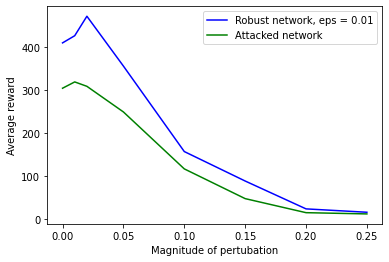

In [19]:
plt.figure(1)
plt.plot(epsilons_attacks,robust_average_rewards[0], "-b",label = "Robust network, eps = 0.01")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

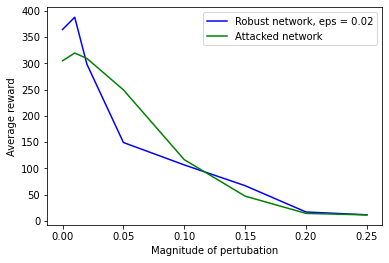

In [20]:
plt.figure(2)
plt.plot(epsilons_attacks,robust_average_rewards[1], "-b",label = "Robust network, eps = 0.02")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

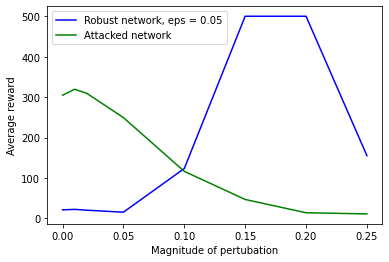

In [21]:
plt.figure(3)
plt.plot(epsilons_attacks,robust_average_rewards[2], "-b",label = "Robust network, eps = 0.05")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

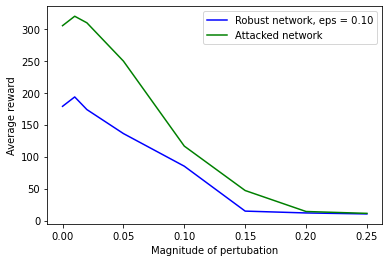

In [22]:
plt.figure(4)
plt.plot(epsilons_attacks,robust_average_rewards[3], "-b",label = "Robust network, eps = 0.10")
plt.plot(epsilons_attacks,average_reward_number_attacked, "-g",label = "Attacked network")
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.legend()
plt.show()

## Smooth like butter

In [ ]:
from scipy.interpolate import make_interp_spline, BSpline
plt.figure(2)
smooth_eps = np.linspace(epsilons_attacks.min(), epsilons_attacks.max(), 300)  
spl = make_interp_spline(epsilons_attacks,average_reward_number_robust , k=3) 
smooth_rewards_robust = spl(smooth_eps)
plt.plot(smooth_eps, smooth_rewards_robust, "-b", label = "Robust network")
spl_2 = make_interp_spline(epsilons_attacks,average_reward_number_attacked , k=3) 
smooth_rewards_attacked = spl_2(smooth_eps)
plt.plot(smooth_eps, smooth_rewards_attacked, "-g", label = "Attacked network")
plt.legend()
plt.xlabel("Magnitude of pertubation")
plt.ylabel("Average reward")
plt.show()